### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [3]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [4]:
!nvidia-smi

Sun Oct  9 10:58:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:21:00.0 Off |                  N/A |
| 36%   54C    P2   155W / 350W |   3713MiB / 24265MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:48:00.0 Off |                  N/A |
| 35%   

In [5]:
from models.unet import UNet

random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [6]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [7]:
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [8]:
train_images = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/images/*')
train_labels = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

# train_images = sorted(train_images)
# train_labels = sorted(train_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)
        
# valid_images = sorted(valid_images)
# valid_labels = sorted(valid_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)

My custom training-dataset has 489 elements
My custom valing-dataset has 123 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

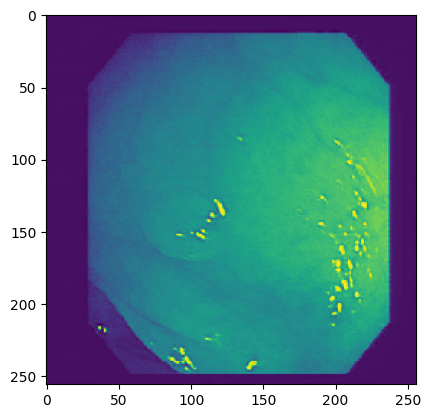

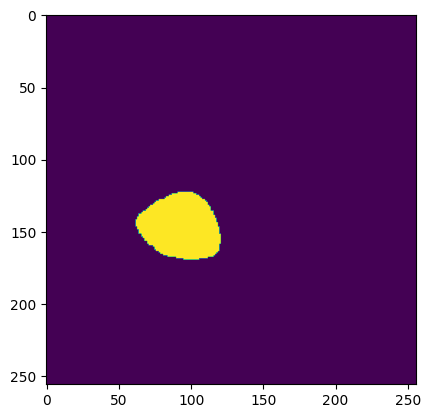

3픽셀의 평균값이라 색깔이 변경됨.


In [9]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [10]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [11]:
# Define variables for the training
epochs = 100
patience = 10
BATCH_SIZE = 16

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [14]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = IoULoss()
# model_name = 'UNet_IoULoss_baseline'

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCELoss_baseline'

criterion = IoUBCELoss()
model_name = 'UNet_IoUBCELoss_baseline'


# 5. Training

In [15]:
def dice_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # (BATCH, 1, H, W) -> (BATCH, H, W)
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    dice = 2 * (intersection + SMOOTH) / (intersection + union + SMOOTH) # We smooth our devision to avoid 0/0

    return dice.mean()

 Epoch: 0 of 100, Iter.: 31 of 31, Train Loss: 0.339847, IoU: 0.223377, Dice: 0.329542
 Epoch: 0 of 100, Iter.: 31 of 31, Valid Loss: 0.505608, IoU: 0.066094, Dice: 0.112831

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


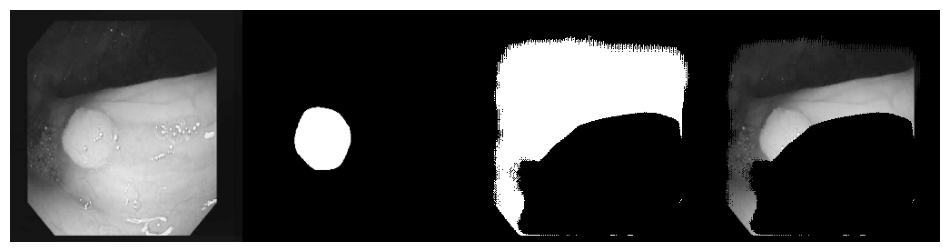

 Epoch: 1 of 100, Iter.: 31 of 31, Train Loss: 0.223714, IoU: 0.286798, Dice: 0.395841
 Epoch: 1 of 100, Iter.: 31 of 31, Valid Loss: 0.312330, IoU: 0.238054, Dice: 0.343902


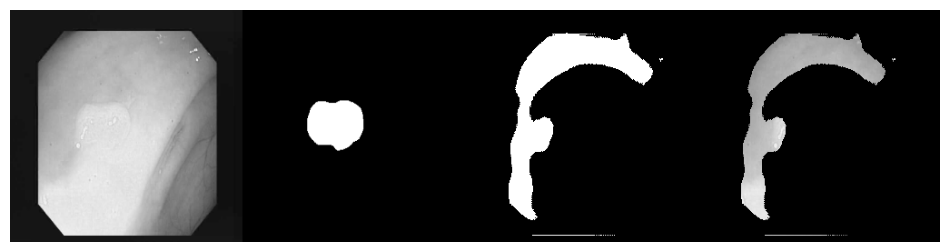

 Epoch: 2 of 100, Iter.: 31 of 31, Train Loss: 0.167603, IoU: 0.334301, Dice: 0.450524
 Epoch: 2 of 100, Iter.: 31 of 31, Valid Loss: 0.226449, IoU: 0.289073, Dice: 0.410358


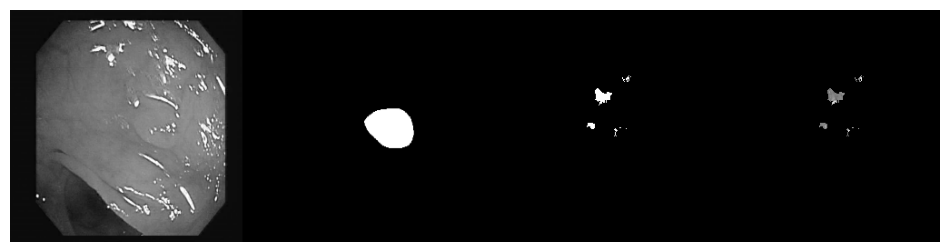

 Epoch: 3 of 100, Iter.: 31 of 31, Train Loss: 0.119954, IoU: 0.370422, Dice: 0.487977
 Epoch: 3 of 100, Iter.: 31 of 31, Valid Loss: 0.153683, IoU: 0.303200, Dice: 0.411907


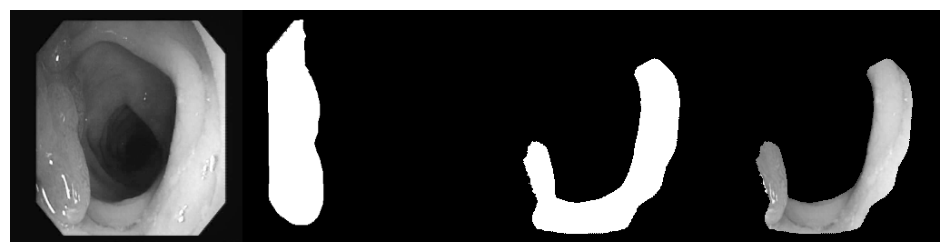

 Epoch: 4 of 100, Iter.: 31 of 31, Train Loss: 0.093112, IoU: 0.379955, Dice: 0.496578
 Epoch: 4 of 100, Iter.: 31 of 31, Valid Loss: 0.143325, IoU: 0.317078, Dice: 0.429625


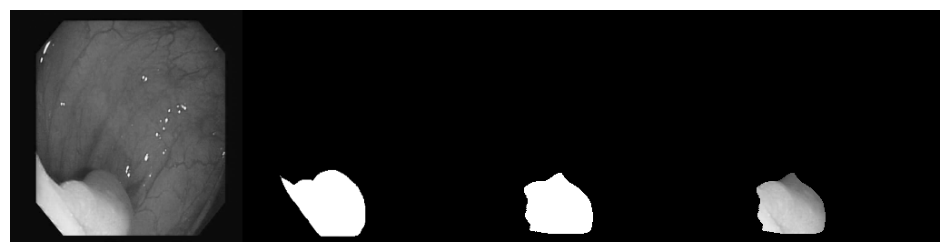

 Epoch: 5 of 100, Iter.: 31 of 31, Train Loss: 0.047006, IoU: 0.413839, Dice: 0.529699
 Epoch: 5 of 100, Iter.: 31 of 31, Valid Loss: 0.087808, IoU: 0.355958, Dice: 0.474486


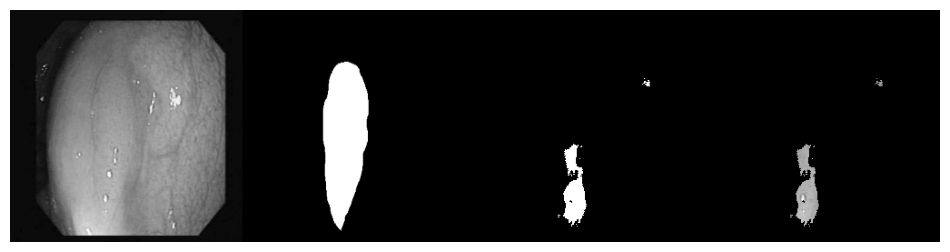

 Epoch: 6 of 100, Iter.: 31 of 31, Train Loss: 0.011083, IoU: 0.453818, Dice: 0.571813
 Epoch: 6 of 100, Iter.: 31 of 31, Valid Loss: 0.048408, IoU: 0.380326, Dice: 0.499441


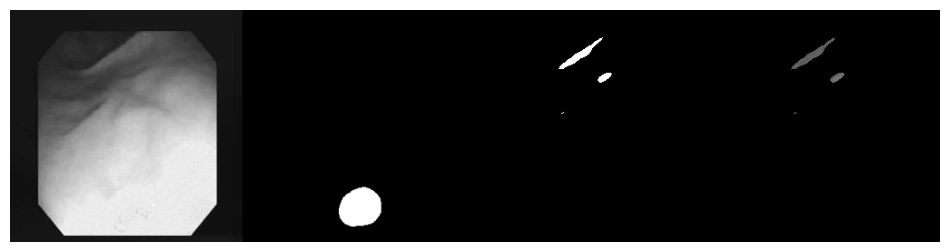

 Epoch: 7 of 100, Iter.: 31 of 31, Train Loss: -0.026177, IoU: 0.491171, Dice: 0.606337
 Epoch: 7 of 100, Iter.: 31 of 31, Valid Loss: 0.081500, IoU: 0.357704, Dice: 0.475909


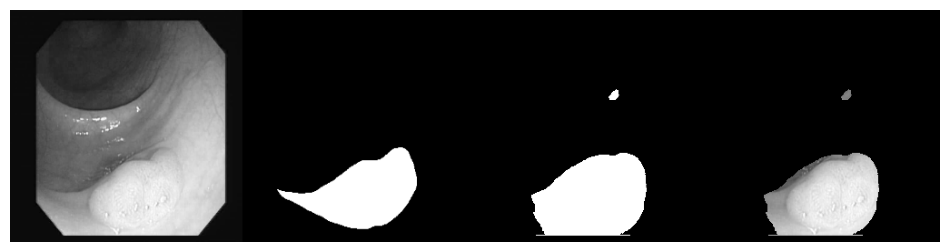

 Epoch: 8 of 100, Iter.: 31 of 31, Train Loss: -0.062795, IoU: 0.513293, Dice: 0.629456
 Epoch: 8 of 100, Iter.: 31 of 31, Valid Loss: 0.002651, IoU: 0.446707, Dice: 0.569672


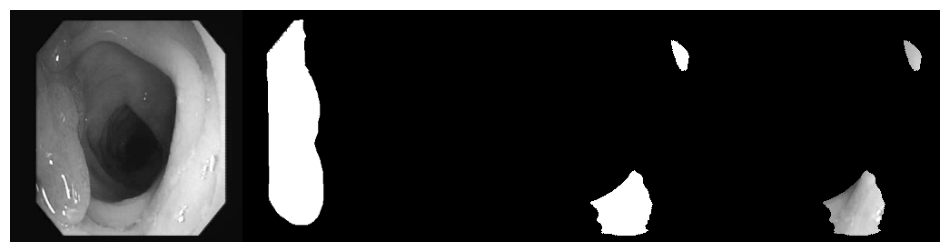

 Epoch: 9 of 100, Iter.: 31 of 31, Train Loss: -0.114321, IoU: 0.562420, Dice: 0.671524
 Epoch: 9 of 100, Iter.: 31 of 31, Valid Loss: -0.023820, IoU: 0.449653, Dice: 0.572206


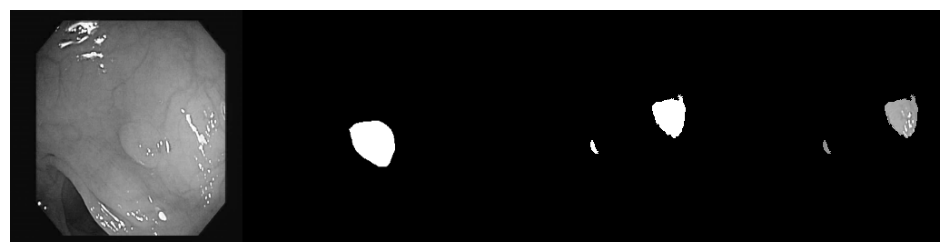

 Epoch: 10 of 100, Iter.: 31 of 31, Train Loss: -0.160222, IoU: 0.600100, Dice: 0.708356
 Epoch: 10 of 100, Iter.: 31 of 31, Valid Loss: -0.052502, IoU: 0.438066, Dice: 0.542196


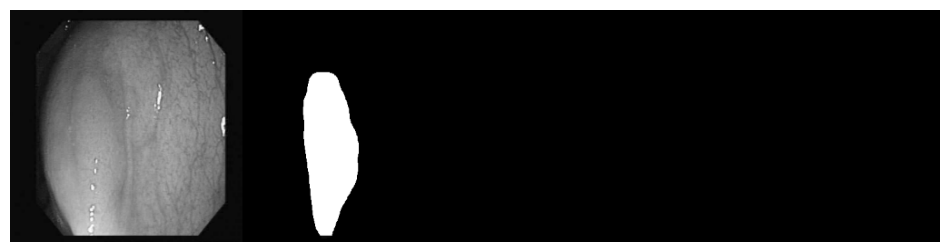

 Epoch: 11 of 100, Iter.: 31 of 31, Train Loss: -0.195997, IoU: 0.627414, Dice: 0.730372
 Epoch: 11 of 100, Iter.: 31 of 31, Valid Loss: -0.115699, IoU: 0.535040, Dice: 0.637627


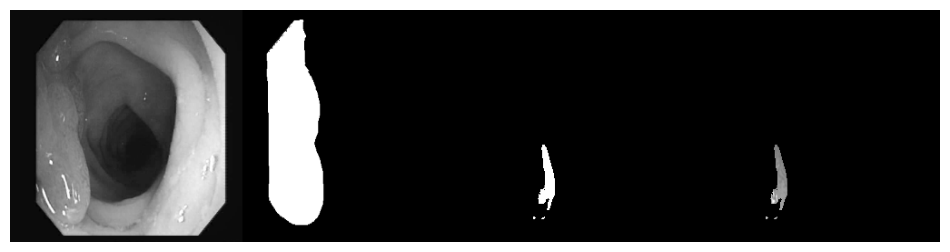

 Epoch: 12 of 100, Iter.: 31 of 31, Train Loss: -0.220158, IoU: 0.638598, Dice: 0.739445
 Epoch: 12 of 100, Iter.: 31 of 31, Valid Loss: -0.121732, IoU: 0.485807, Dice: 0.593916


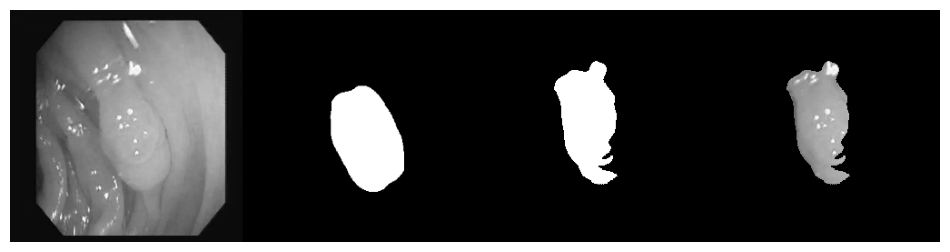

 Epoch: 13 of 100, Iter.: 31 of 31, Train Loss: -0.244994, IoU: 0.645052, Dice: 0.743944
 Epoch: 13 of 100, Iter.: 31 of 31, Valid Loss: -0.124779, IoU: 0.480521, Dice: 0.584336


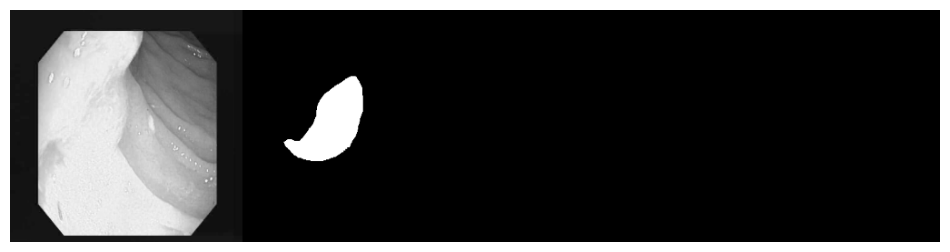

 Epoch: 14 of 100, Iter.: 31 of 31, Train Loss: -0.294288, IoU: 0.678911, Dice: 0.774586
 Epoch: 14 of 100, Iter.: 31 of 31, Valid Loss: -0.146761, IoU: 0.442086, Dice: 0.534007


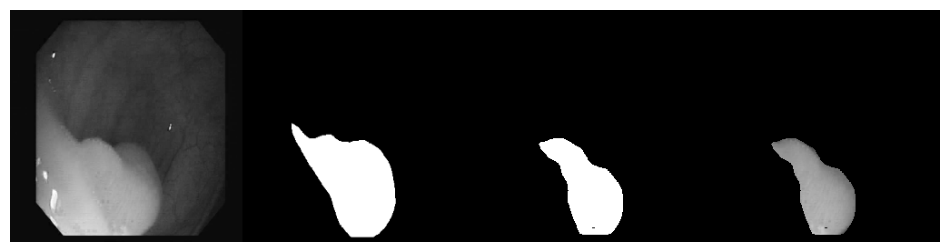

 Epoch: 15 of 100, Iter.: 31 of 31, Train Loss: -0.323680, IoU: 0.693238, Dice: 0.783604
 Epoch: 15 of 100, Iter.: 31 of 31, Valid Loss: -0.194263, IoU: 0.544469, Dice: 0.637481


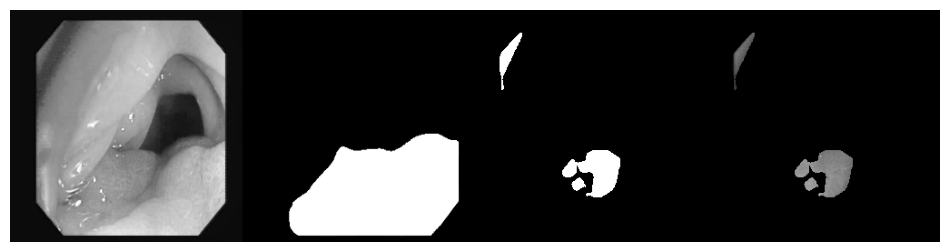

 Epoch: 16 of 100, Iter.: 31 of 31, Train Loss: -0.356997, IoU: 0.699110, Dice: 0.786498
 Epoch: 16 of 100, Iter.: 31 of 31, Valid Loss: -0.182929, IoU: 0.497169, Dice: 0.586621


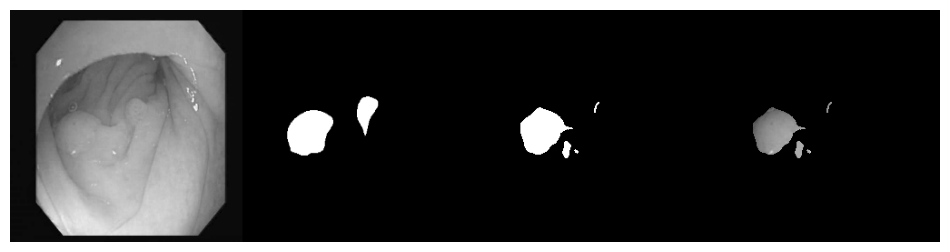

 Epoch: 17 of 100, Iter.: 31 of 31, Train Loss: -0.381973, IoU: 0.713282, Dice: 0.802296
 Epoch: 17 of 100, Iter.: 31 of 31, Valid Loss: -0.212093, IoU: 0.533581, Dice: 0.633069


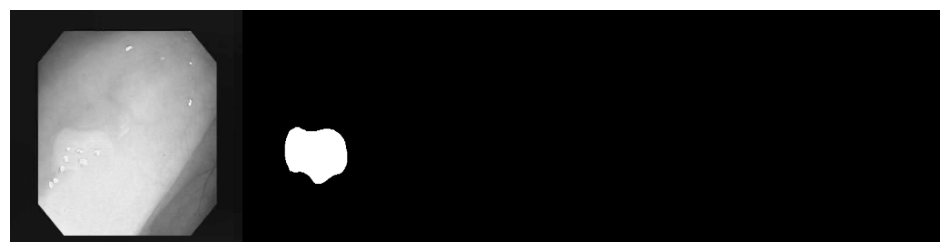

 Epoch: 18 of 100, Iter.: 31 of 31, Train Loss: -0.390999, IoU: 0.722496, Dice: 0.808689
 Epoch: 18 of 100, Iter.: 31 of 31, Valid Loss: -0.229429, IoU: 0.536916, Dice: 0.640512


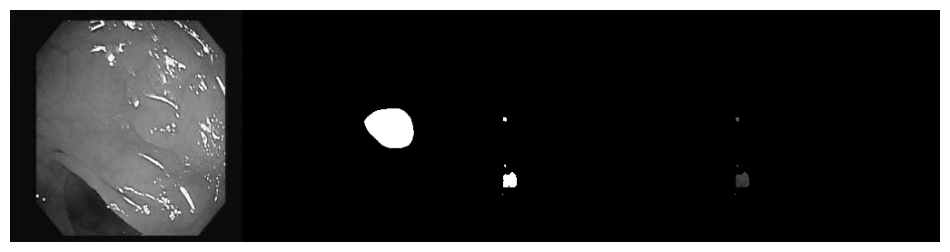

 Epoch: 19 of 100, Iter.: 31 of 31, Train Loss: -0.414579, IoU: 0.724834, Dice: 0.810890
 Epoch: 19 of 100, Iter.: 31 of 31, Valid Loss: -0.268453, IoU: 0.579442, Dice: 0.684291


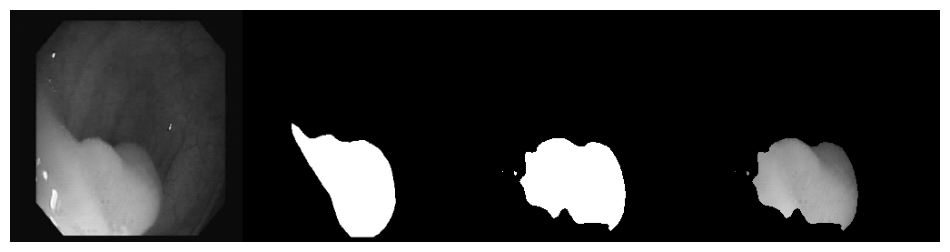

 Epoch: 20 of 100, Iter.: 31 of 31, Train Loss: -0.465097, IoU: 0.757048, Dice: 0.836901
 Epoch: 20 of 100, Iter.: 31 of 31, Valid Loss: -0.167281, IoU: 0.491582, Dice: 0.610911


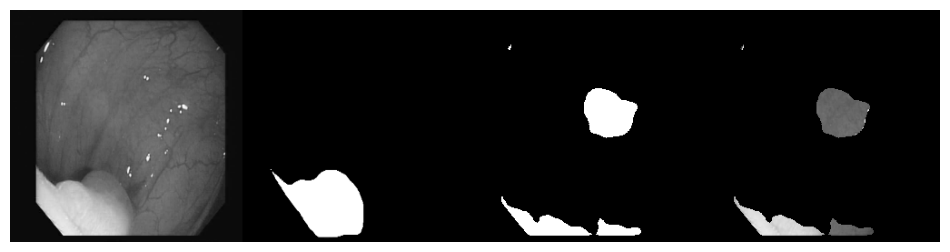

 Epoch: 21 of 100, Iter.: 31 of 31, Train Loss: -0.494094, IoU: 0.772999, Dice: 0.849036
 Epoch: 21 of 100, Iter.: 31 of 31, Valid Loss: -0.278678, IoU: 0.524507, Dice: 0.608387


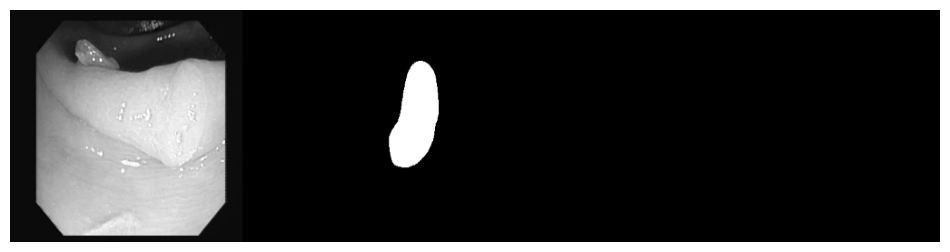

 Epoch: 22 of 100, Iter.: 31 of 31, Train Loss: -0.539047, IoU: 0.802748, Dice: 0.871629
 Epoch: 22 of 100, Iter.: 31 of 31, Valid Loss: -0.388686, IoU: 0.661877, Dice: 0.754856


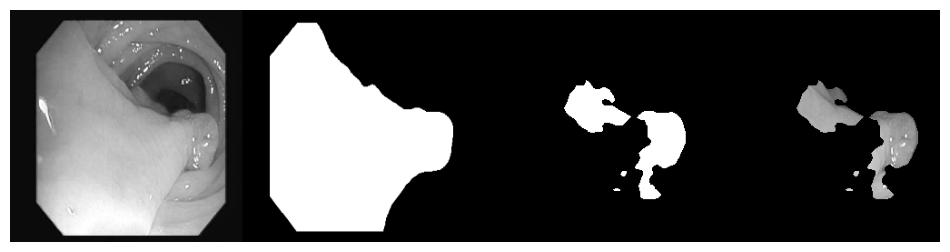

 Epoch: 23 of 100, Iter.: 31 of 31, Train Loss: -0.566034, IoU: 0.806651, Dice: 0.872256
 Epoch: 23 of 100, Iter.: 31 of 31, Valid Loss: -0.371277, IoU: 0.611549, Dice: 0.698801


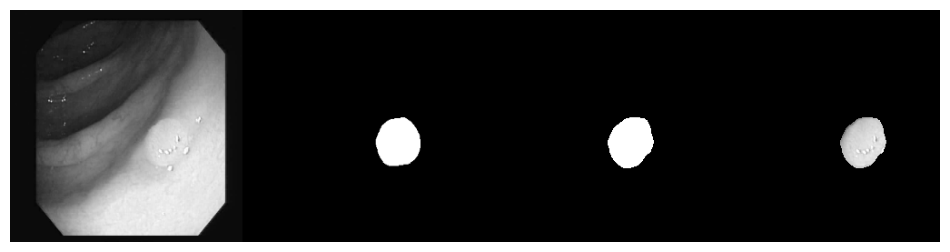

 Epoch: 24 of 100, Iter.: 31 of 31, Train Loss: -0.580800, IoU: 0.815319, Dice: 0.879531
 Epoch: 24 of 100, Iter.: 31 of 31, Valid Loss: -0.375905, IoU: 0.631937, Dice: 0.724292


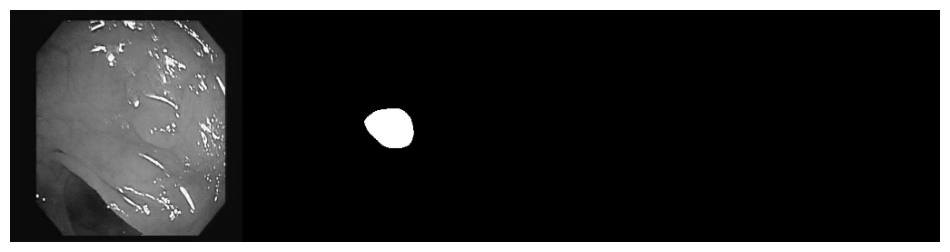

 Epoch: 25 of 100, Iter.: 31 of 31, Train Loss: -0.623140, IoU: 0.840592, Dice: 0.897331
 Epoch: 25 of 100, Iter.: 31 of 31, Valid Loss: -0.436995, IoU: 0.700273, Dice: 0.790208


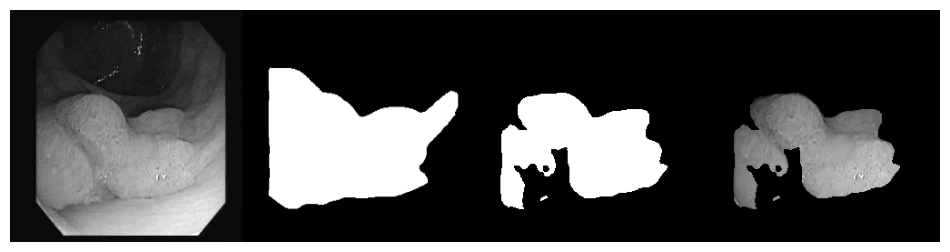

 Epoch: 26 of 100, Iter.: 31 of 31, Train Loss: -0.631329, IoU: 0.840232, Dice: 0.898181
 Epoch: 26 of 100, Iter.: 31 of 31, Valid Loss: -0.371013, IoU: 0.604782, Dice: 0.713433


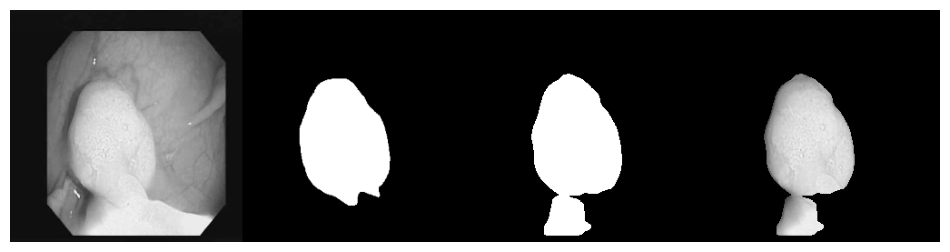

 Epoch: 27 of 100, Iter.: 31 of 31, Train Loss: -0.612676, IoU: 0.799790, Dice: 0.867938
 Epoch: 27 of 100, Iter.: 31 of 31, Valid Loss: -0.439485, IoU: 0.666876, Dice: 0.760227


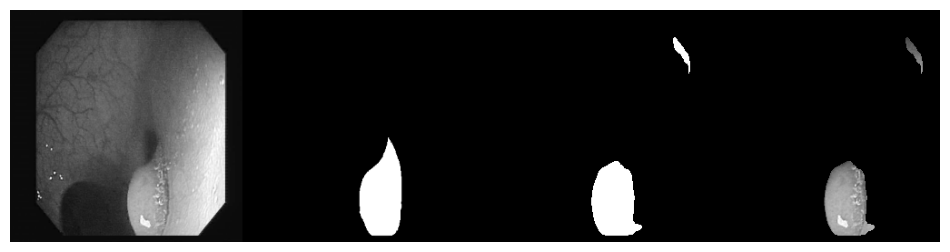

 Epoch: 28 of 100, Iter.: 31 of 31, Train Loss: -0.636408, IoU: 0.824952, Dice: 0.888504
 Epoch: 28 of 100, Iter.: 31 of 31, Valid Loss: -0.441644, IoU: 0.648417, Dice: 0.749934


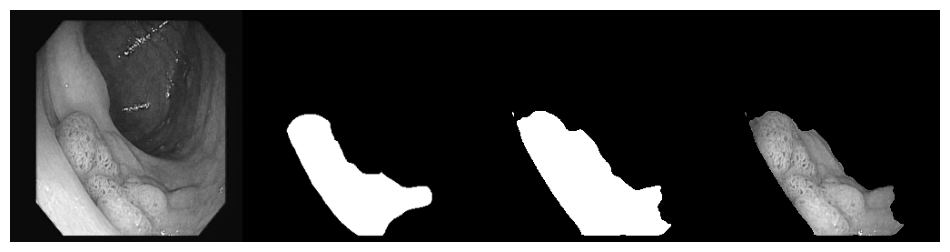

 Epoch: 29 of 100, Iter.: 31 of 31, Train Loss: -0.659552, IoU: 0.833501, Dice: 0.896697
 Epoch: 29 of 100, Iter.: 31 of 31, Valid Loss: -0.470566, IoU: 0.653860, Dice: 0.745068


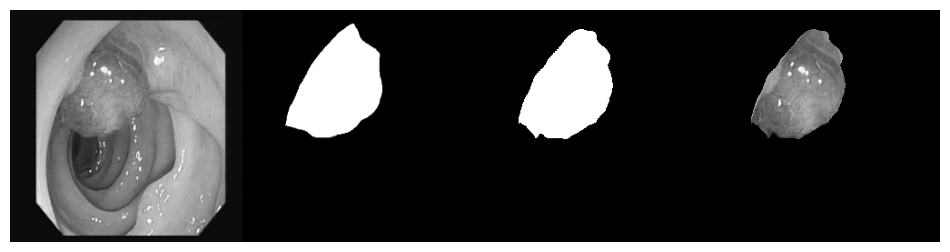

 Epoch: 30 of 100, Iter.: 31 of 31, Train Loss: -0.679831, IoU: 0.837885, Dice: 0.896554
 Epoch: 30 of 100, Iter.: 31 of 31, Valid Loss: -0.364431, IoU: 0.556037, Dice: 0.656009


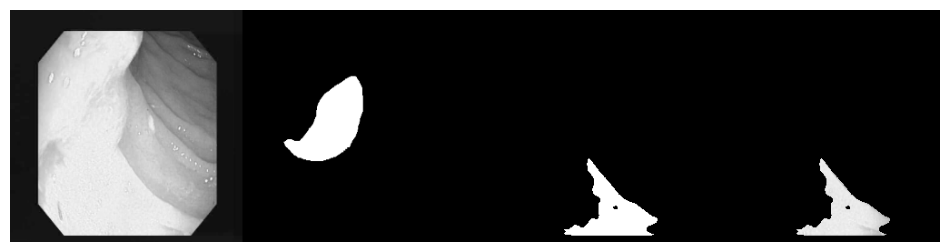

 Epoch: 31 of 100, Iter.: 31 of 31, Train Loss: -0.685235, IoU: 0.841402, Dice: 0.900995
 Epoch: 31 of 100, Iter.: 31 of 31, Valid Loss: -0.511205, IoU: 0.690755, Dice: 0.774061


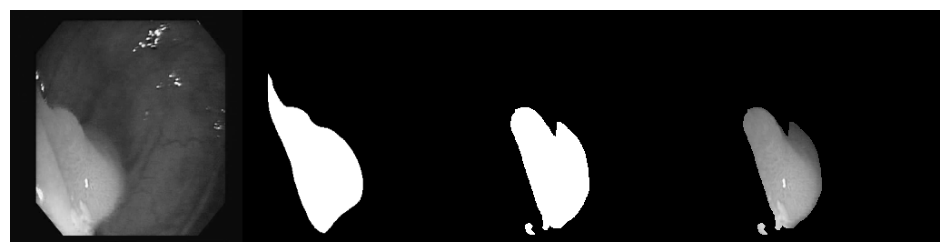

 Epoch: 32 of 100, Iter.: 31 of 31, Train Loss: -0.710665, IoU: 0.856218, Dice: 0.909738
 Epoch: 32 of 100, Iter.: 31 of 31, Valid Loss: -0.492256, IoU: 0.656390, Dice: 0.737352


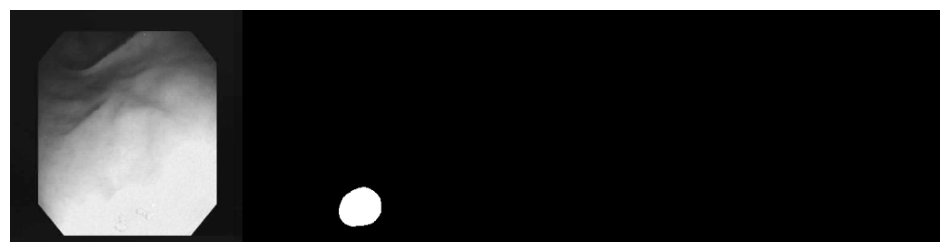

 Epoch: 33 of 100, Iter.: 31 of 31, Train Loss: -0.735300, IoU: 0.868743, Dice: 0.918485
 Epoch: 33 of 100, Iter.: 31 of 31, Valid Loss: -0.518091, IoU: 0.697063, Dice: 0.779167


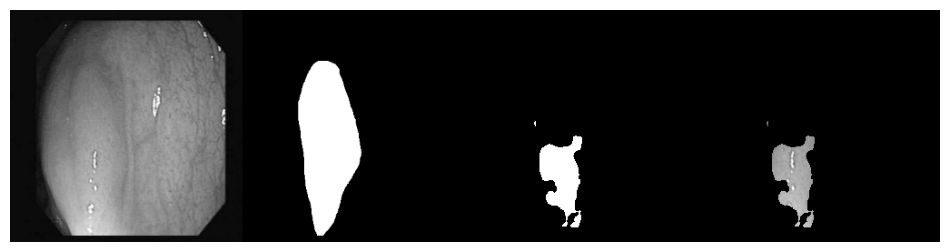

 Epoch: 34 of 100, Iter.: 31 of 31, Train Loss: -0.748338, IoU: 0.867642, Dice: 0.916611
 Epoch: 34 of 100, Iter.: 31 of 31, Valid Loss: -0.420266, IoU: 0.586646, Dice: 0.668210


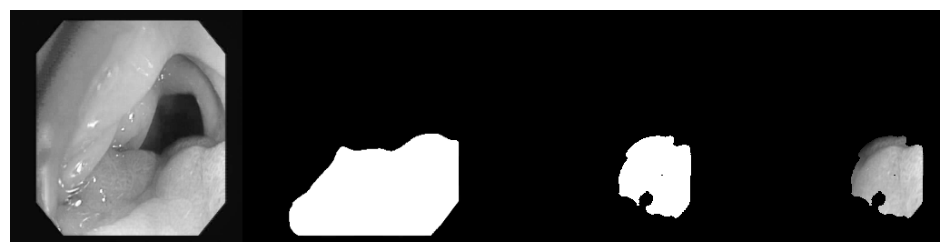

 Epoch: 35 of 100, Iter.: 31 of 31, Train Loss: -0.766904, IoU: 0.882925, Dice: 0.928483
 Epoch: 35 of 100, Iter.: 31 of 31, Valid Loss: -0.524708, IoU: 0.716585, Dice: 0.804235


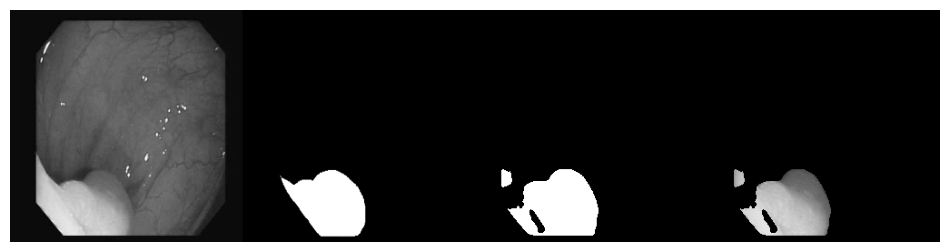

 Epoch: 36 of 100, Iter.: 31 of 31, Train Loss: -0.777598, IoU: 0.887863, Dice: 0.931770
 Epoch: 36 of 100, Iter.: 31 of 31, Valid Loss: -0.534475, IoU: 0.714047, Dice: 0.795536


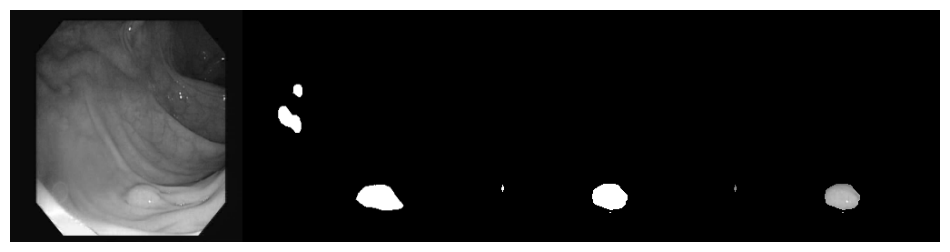

 Epoch: 37 of 100, Iter.: 31 of 31, Train Loss: -0.782721, IoU: 0.888371, Dice: 0.932350
 Epoch: 37 of 100, Iter.: 31 of 31, Valid Loss: -0.575267, IoU: 0.723992, Dice: 0.805250


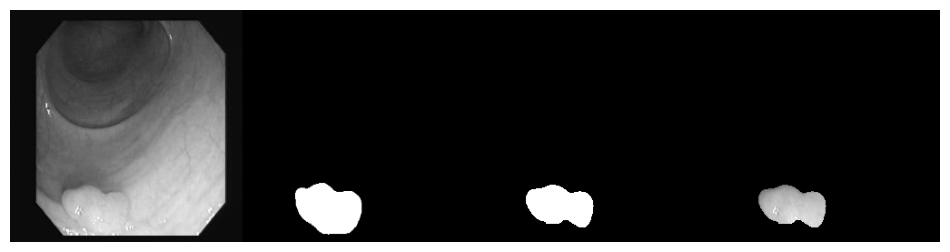

 Epoch: 38 of 100, Iter.: 31 of 31, Train Loss: -0.796581, IoU: 0.895254, Dice: 0.936429
 Epoch: 38 of 100, Iter.: 31 of 31, Valid Loss: -0.558793, IoU: 0.720098, Dice: 0.800821


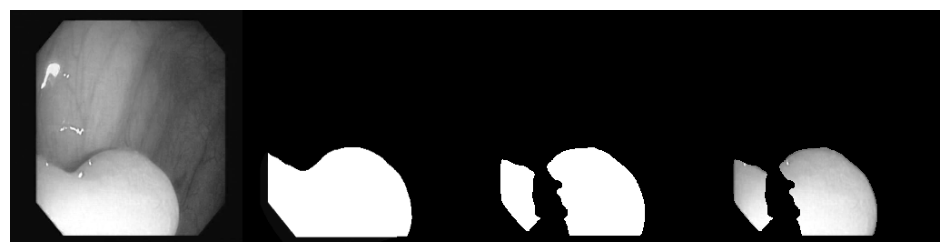

 Epoch: 39 of 100, Iter.: 31 of 31, Train Loss: -0.806508, IoU: 0.902222, Dice: 0.940725
 Epoch: 39 of 100, Iter.: 31 of 31, Valid Loss: -0.573657, IoU: 0.726888, Dice: 0.806614


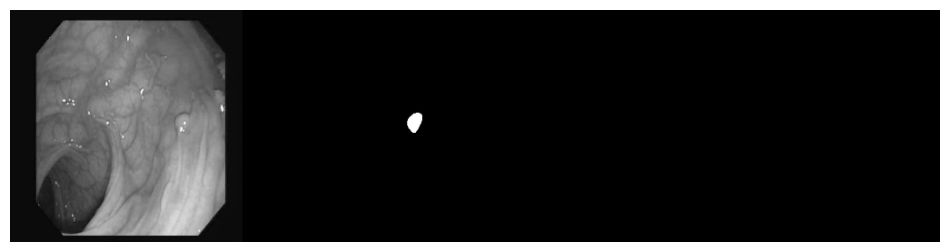

 Epoch: 40 of 100, Iter.: 31 of 31, Train Loss: -0.811466, IoU: 0.903313, Dice: 0.940892
 Epoch: 40 of 100, Iter.: 31 of 31, Valid Loss: -0.541428, IoU: 0.706930, Dice: 0.798916


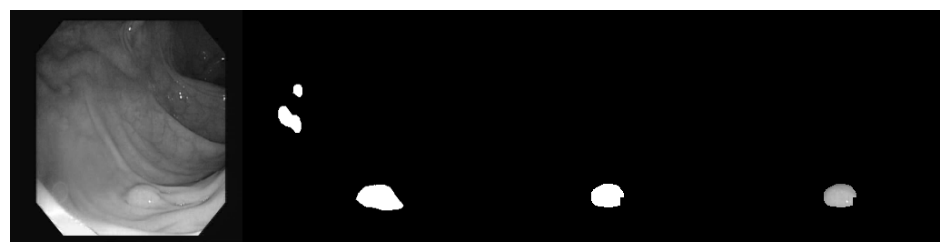

 Epoch: 41 of 100, Iter.: 31 of 31, Train Loss: -0.806998, IoU: 0.889846, Dice: 0.932460
 Epoch: 41 of 100, Iter.: 31 of 31, Valid Loss: -0.562034, IoU: 0.700160, Dice: 0.786232


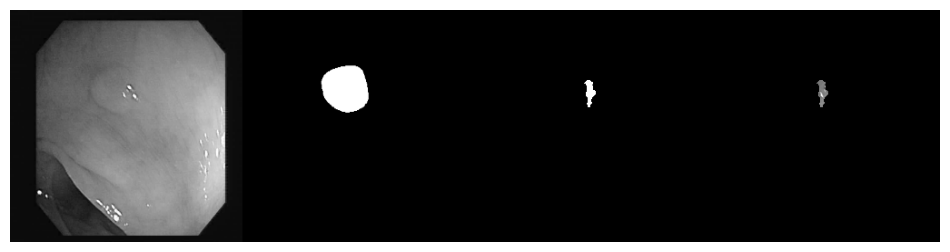

 Epoch: 42 of 100, Iter.: 31 of 31, Train Loss: -0.815517, IoU: 0.890083, Dice: 0.931366
 Epoch: 42 of 100, Iter.: 31 of 31, Valid Loss: -0.612581, IoU: 0.751027, Dice: 0.830387


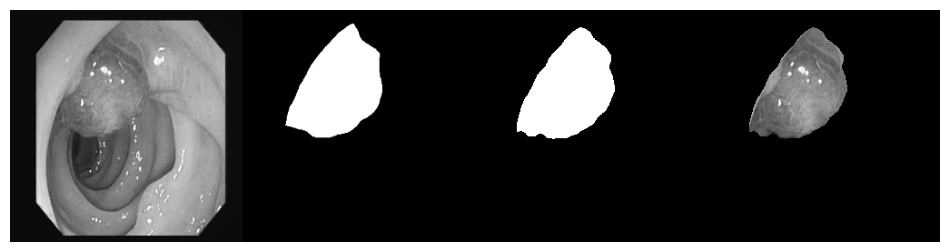

 Epoch: 43 of 100, Iter.: 31 of 31, Train Loss: -0.824875, IoU: 0.899268, Dice: 0.938279
 Epoch: 43 of 100, Iter.: 31 of 31, Valid Loss: -0.573051, IoU: 0.709969, Dice: 0.796967


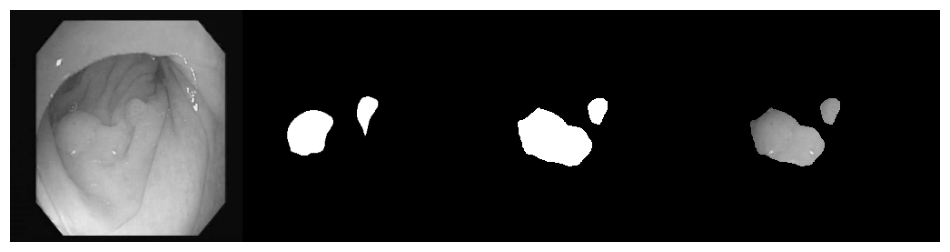

 Epoch: 44 of 100, Iter.: 31 of 31, Train Loss: -0.832157, IoU: 0.898254, Dice: 0.937373
 Epoch: 44 of 100, Iter.: 31 of 31, Valid Loss: -0.594448, IoU: 0.728017, Dice: 0.810792


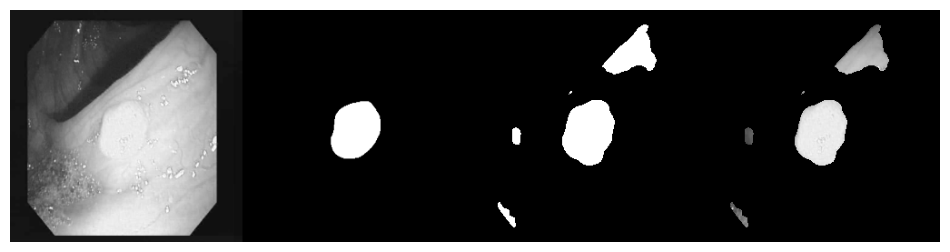

 Epoch: 45 of 100, Iter.: 31 of 31, Train Loss: -0.837374, IoU: 0.903023, Dice: 0.940331
 Epoch: 45 of 100, Iter.: 31 of 31, Valid Loss: -0.606202, IoU: 0.736881, Dice: 0.817707


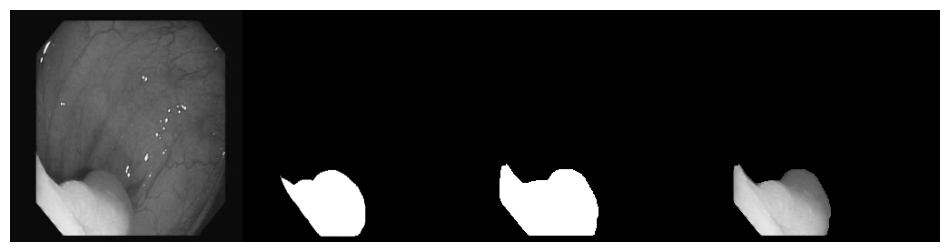

 Epoch: 46 of 100, Iter.: 31 of 31, Train Loss: -0.757067, IoU: 0.838770, Dice: 0.894329
 Epoch: 46 of 100, Iter.: 31 of 31, Valid Loss: -0.002079, IoU: 0.456843, Dice: 0.576431


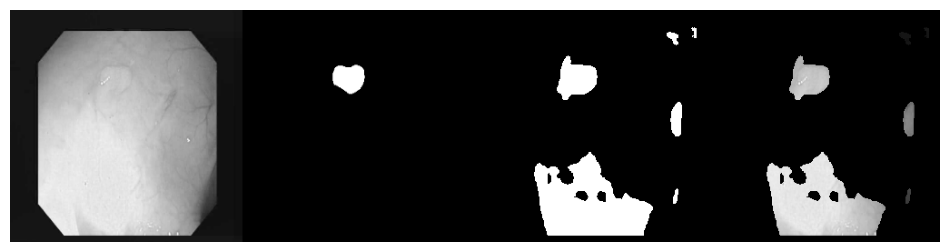

 Epoch: 47 of 100, Iter.: 31 of 31, Train Loss: -0.696475, IoU: 0.787253, Dice: 0.858949
 Epoch: 47 of 100, Iter.: 31 of 31, Valid Loss: -0.418959, IoU: 0.582345, Dice: 0.673873


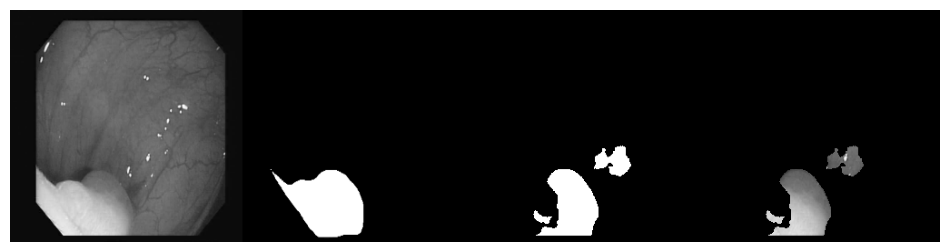

 Epoch: 48 of 100, Iter.: 31 of 31, Train Loss: -0.756678, IoU: 0.832393, Dice: 0.892293
 Epoch: 48 of 100, Iter.: 31 of 31, Valid Loss: -0.485527, IoU: 0.642048, Dice: 0.738856


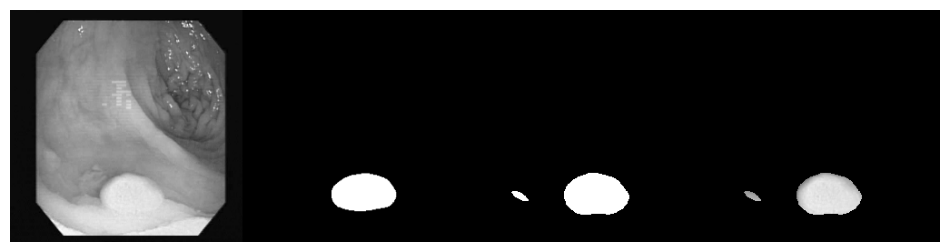

 Epoch: 49 of 100, Iter.: 31 of 31, Train Loss: -0.790538, IoU: 0.855525, Dice: 0.908857
 Epoch: 49 of 100, Iter.: 31 of 31, Valid Loss: -0.600326, IoU: 0.719632, Dice: 0.799120


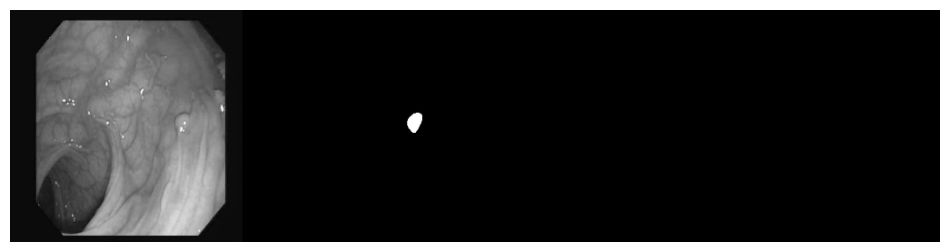

 Epoch: 50 of 100, Iter.: 31 of 31, Train Loss: -0.828453, IoU: 0.884772, Dice: 0.928911
 Epoch: 50 of 100, Iter.: 31 of 31, Valid Loss: -0.612344, IoU: 0.736391, Dice: 0.818197


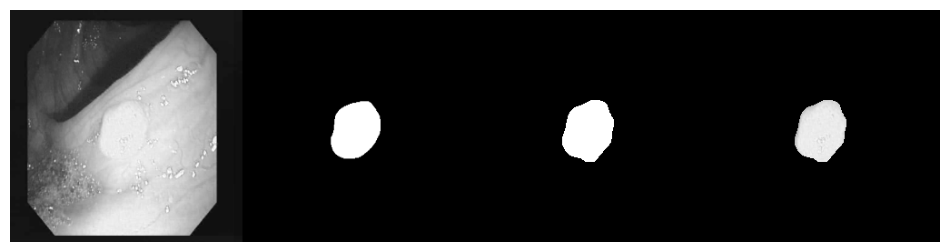

 Epoch: 51 of 100, Iter.: 31 of 31, Train Loss: -0.839880, IoU: 0.893883, Dice: 0.935060
 Epoch: 51 of 100, Iter.: 31 of 31, Valid Loss: -0.521568, IoU: 0.669584, Dice: 0.754647


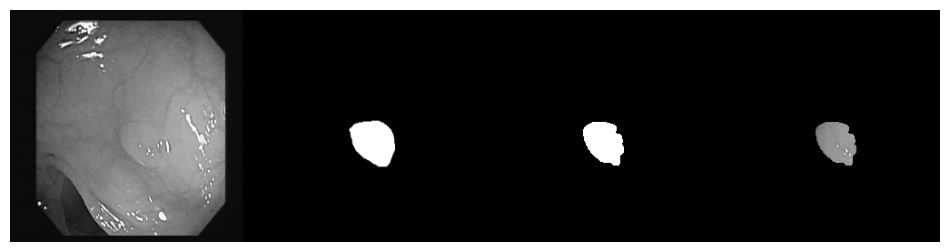

 Epoch: 52 of 100, Iter.: 31 of 31, Train Loss: -0.836634, IoU: 0.885152, Dice: 0.930207
 Epoch: 52 of 100, Iter.: 31 of 31, Valid Loss: -0.582882, IoU: 0.702538, Dice: 0.786610


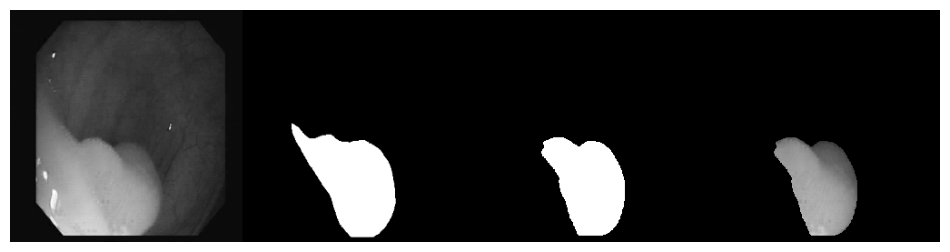

 Epoch: 53 of 100, Iter.: 31 of 31, Train Loss: -0.839767, IoU: 0.888693, Dice: 0.932305
 Epoch: 53 of 100, Iter.: 31 of 31, Valid Loss: -0.491939, IoU: 0.646880, Dice: 0.740053


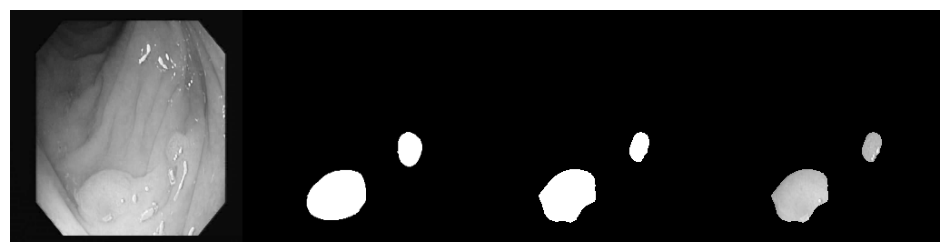

 Epoch: 54 of 100, Iter.: 31 of 31, Train Loss: -0.858790, IoU: 0.898652, Dice: 0.937521
 Epoch: 54 of 100, Iter.: 31 of 31, Valid Loss: -0.601764, IoU: 0.713455, Dice: 0.790009


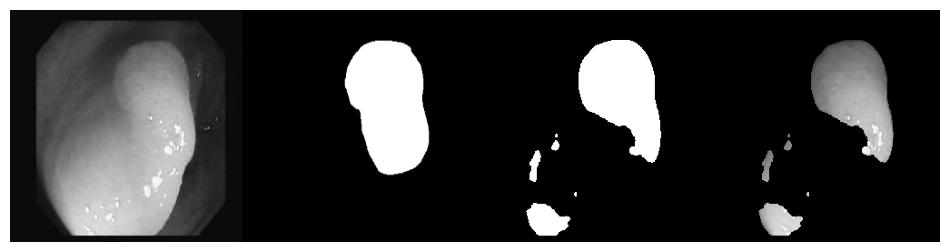

 Epoch: 55 of 100, Iter.: 31 of 31, Train Loss: -0.876392, IoU: 0.917476, Dice: 0.949460
 Epoch: 55 of 100, Iter.: 31 of 31, Valid Loss: -0.611923, IoU: 0.734641, Dice: 0.809331


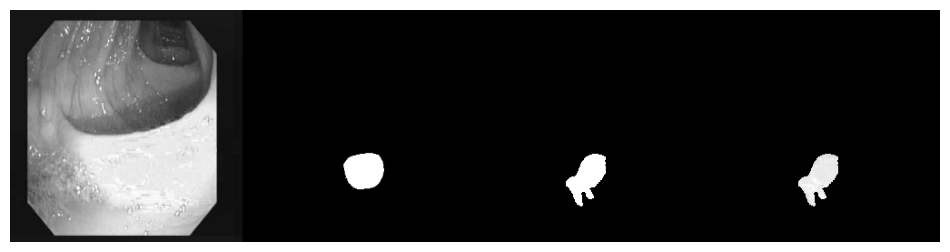

 Epoch: 56 of 100, Iter.: 31 of 31, Train Loss: -0.884077, IoU: 0.922440, Dice: 0.952138
 Epoch: 56 of 100, Iter.: 31 of 31, Valid Loss: -0.605953, IoU: 0.733251, Dice: 0.809241


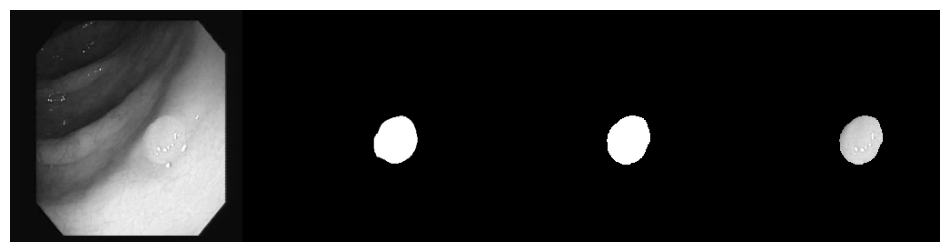

 Epoch: 57 of 100, Iter.: 31 of 31, Train Loss: -0.887808, IoU: 0.923445, Dice: 0.952739
 Epoch: 57 of 100, Iter.: 31 of 31, Valid Loss: -0.607392, IoU: 0.729989, Dice: 0.808288


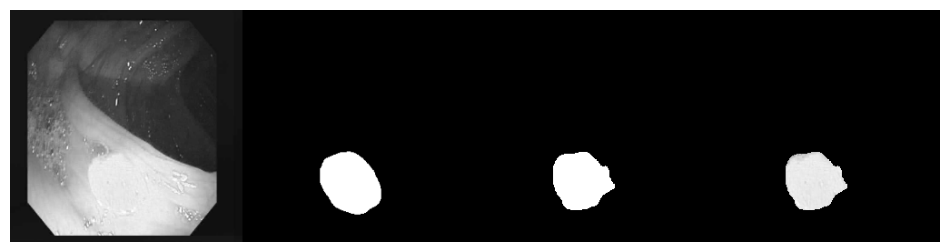

 Epoch: 58 of 100, Iter.: 31 of 31, Train Loss: -0.890084, IoU: 0.925147, Dice: 0.953608
 Epoch: 58 of 100, Iter.: 31 of 31, Valid Loss: -0.580071, IoU: 0.707816, Dice: 0.787029


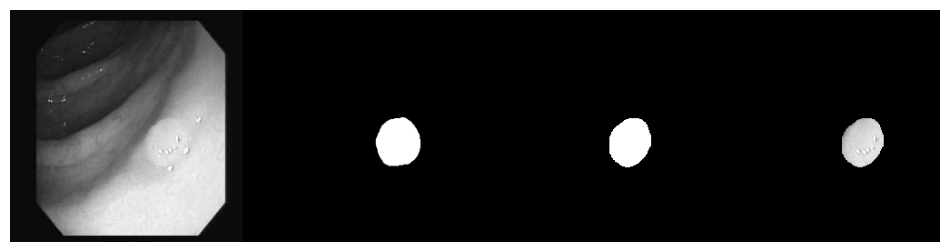

 Epoch: 59 of 100, Iter.: 31 of 31, Train Loss: -0.896262, IoU: 0.927625, Dice: 0.954796
 Epoch: 59 of 100, Iter.: 31 of 31, Valid Loss: -0.614057, IoU: 0.737246, Dice: 0.812869


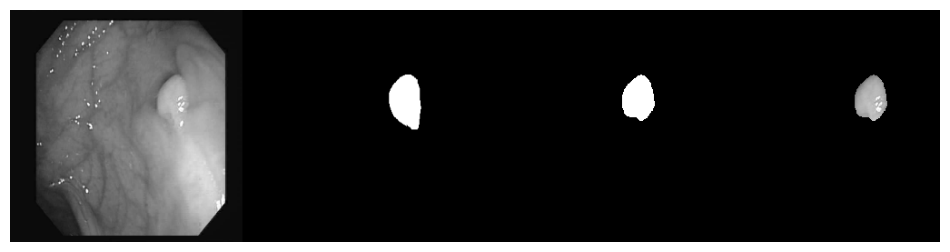

 Epoch: 60 of 100, Iter.: 31 of 31, Train Loss: -0.897383, IoU: 0.928216, Dice: 0.955348
 Epoch: 60 of 100, Iter.: 31 of 31, Valid Loss: -0.602534, IoU: 0.734933, Dice: 0.814064


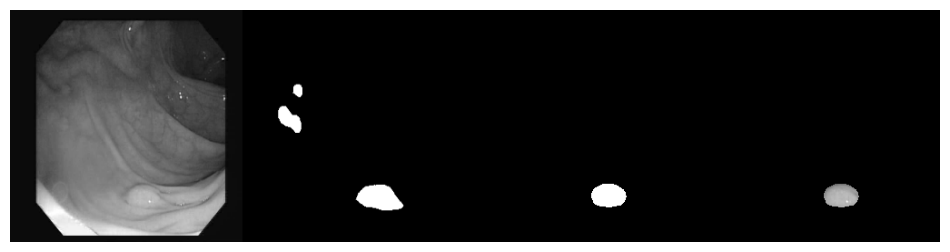

 Epoch: 61 of 100, Iter.: 31 of 31, Train Loss: -0.899853, IoU: 0.928451, Dice: 0.955469
 Epoch: 61 of 100, Iter.: 31 of 31, Valid Loss: -0.611844, IoU: 0.734947, Dice: 0.813677


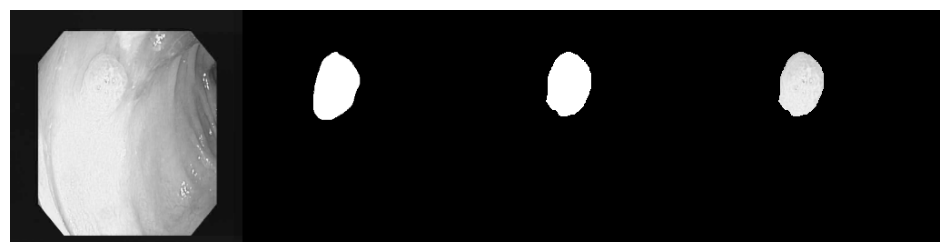

 Epoch: 62 of 100, Iter.: 31 of 31, Train Loss: -0.901711, IoU: 0.928286, Dice: 0.955428
 Epoch: 62 of 100, Iter.: 31 of 31, Valid Loss: -0.608863, IoU: 0.735344, Dice: 0.813058


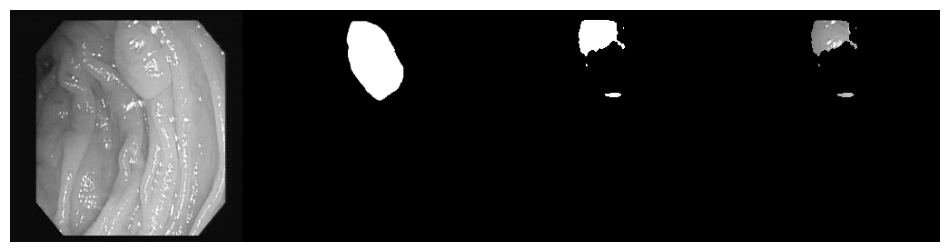

 Epoch: 63 of 100, Iter.: 31 of 31, Train Loss: -0.904681, IoU: 0.931310, Dice: 0.957154
 Epoch: 63 of 100, Iter.: 31 of 31, Valid Loss: -0.619658, IoU: 0.739173, Dice: 0.818603


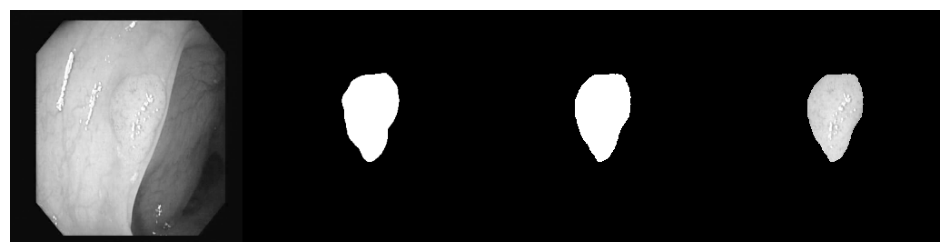

 Epoch: 64 of 100, Iter.: 31 of 31, Train Loss: -0.909144, IoU: 0.932832, Dice: 0.957395
 Epoch: 64 of 100, Iter.: 31 of 31, Valid Loss: -0.604770, IoU: 0.730484, Dice: 0.808183


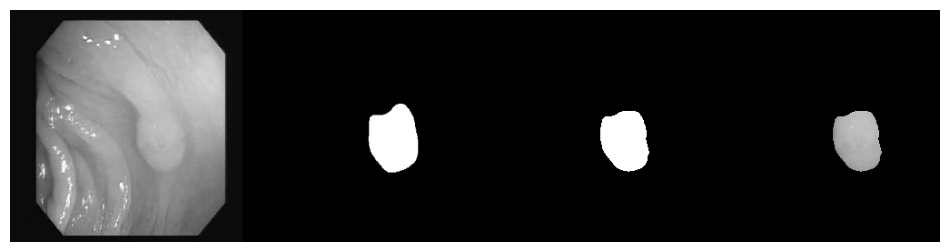

 Epoch: 65 of 100, Iter.: 31 of 31, Train Loss: -0.912502, IoU: 0.935829, Dice: 0.959977
 Epoch: 65 of 100, Iter.: 31 of 31, Valid Loss: -0.628456, IoU: 0.741824, Dice: 0.820884


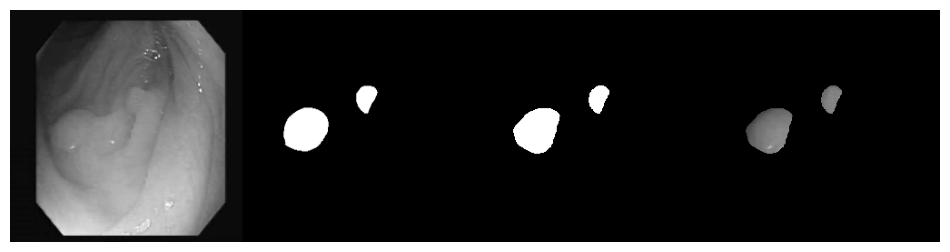

 Epoch: 66 of 100, Iter.: 31 of 31, Train Loss: -0.915171, IoU: 0.938216, Dice: 0.961389
 Epoch: 66 of 100, Iter.: 31 of 31, Valid Loss: -0.620531, IoU: 0.743085, Dice: 0.819356


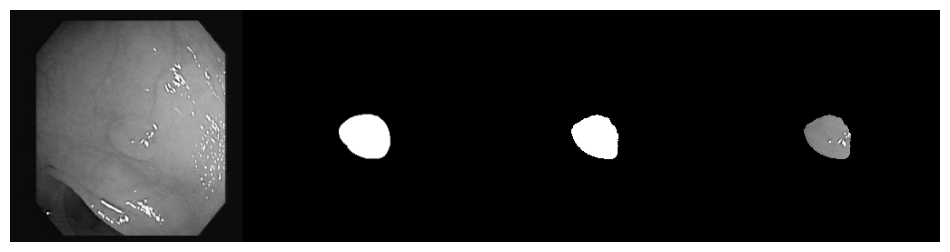

 Epoch: 67 of 100, Iter.: 31 of 31, Train Loss: -0.914358, IoU: 0.936311, Dice: 0.960343
 Epoch: 67 of 100, Iter.: 31 of 31, Valid Loss: -0.619198, IoU: 0.741668, Dice: 0.819170


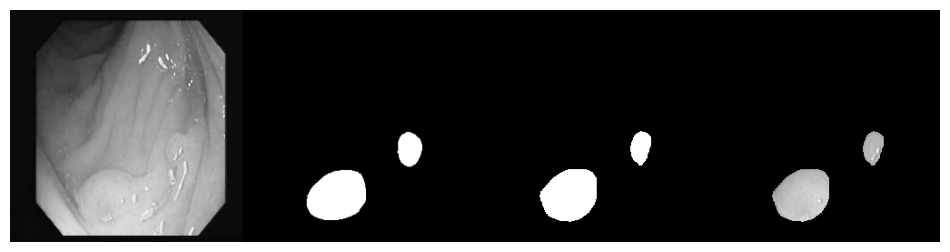

 Epoch: 68 of 100, Iter.: 31 of 31, Train Loss: -0.920437, IoU: 0.940235, Dice: 0.962687
 Epoch: 68 of 100, Iter.: 31 of 31, Valid Loss: -0.615984, IoU: 0.743745, Dice: 0.823244


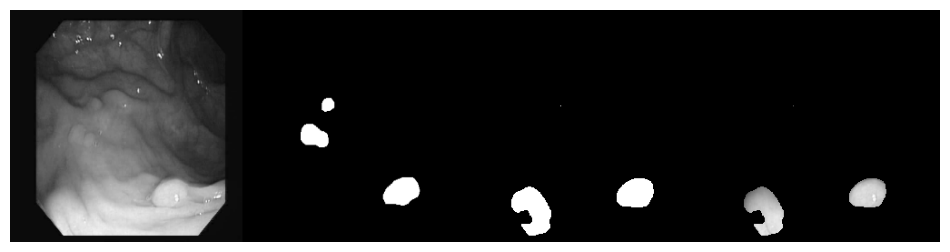

 Epoch: 69 of 100, Iter.: 31 of 31, Train Loss: -0.921347, IoU: 0.940820, Dice: 0.963095
 Epoch: 69 of 100, Iter.: 31 of 31, Valid Loss: -0.617374, IoU: 0.746167, Dice: 0.822899


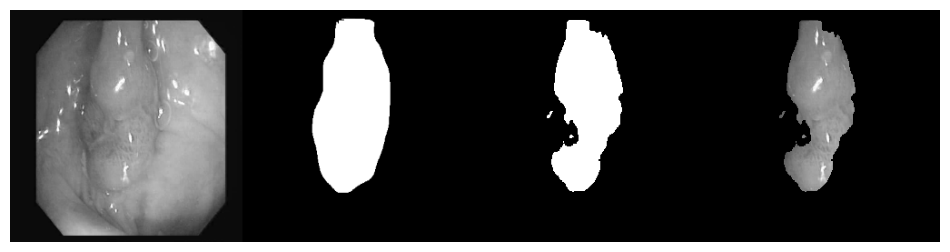

 Epoch: 70 of 100, Iter.: 31 of 31, Train Loss: -0.921333, IoU: 0.941968, Dice: 0.964293
 Epoch: 70 of 100, Iter.: 31 of 31, Valid Loss: -0.633824, IoU: 0.747920, Dice: 0.825197


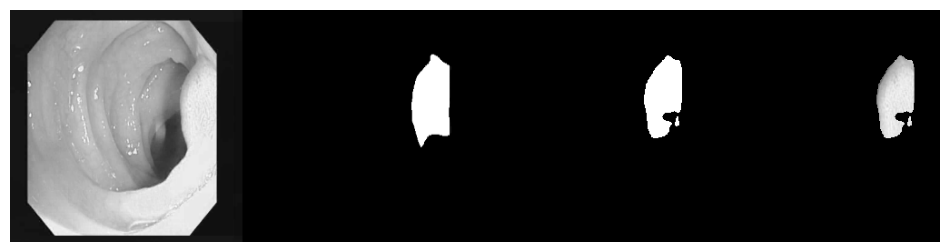

 Epoch: 71 of 100, Iter.: 31 of 31, Train Loss: -0.923305, IoU: 0.940845, Dice: 0.963664
 Epoch: 71 of 100, Iter.: 31 of 31, Valid Loss: -0.618946, IoU: 0.743304, Dice: 0.820581


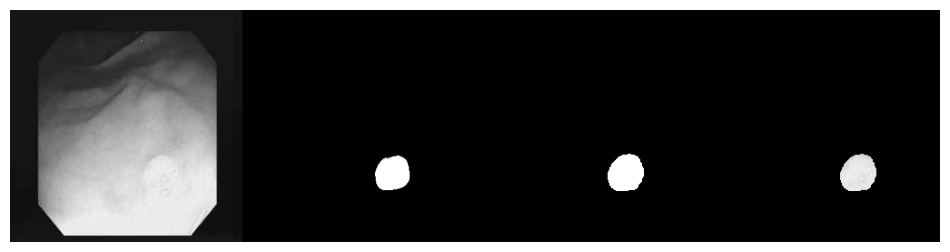

 Epoch: 72 of 100, Iter.: 31 of 31, Train Loss: -0.927620, IoU: 0.943942, Dice: 0.964921
 Epoch: 72 of 100, Iter.: 31 of 31, Valid Loss: -0.618140, IoU: 0.740732, Dice: 0.819958


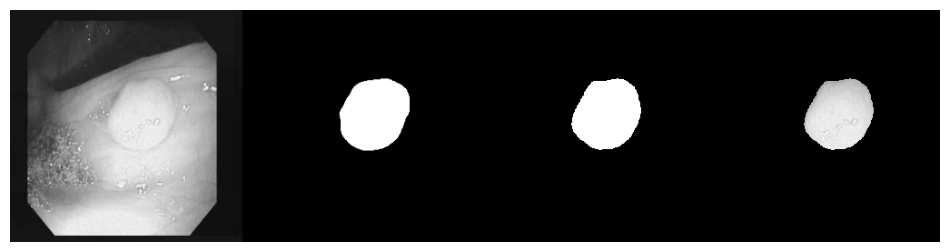

 Epoch: 73 of 100, Iter.: 31 of 31, Train Loss: -0.929629, IoU: 0.947066, Dice: 0.967831
 Epoch: 73 of 100, Iter.: 31 of 31, Valid Loss: -0.606188, IoU: 0.737871, Dice: 0.816838


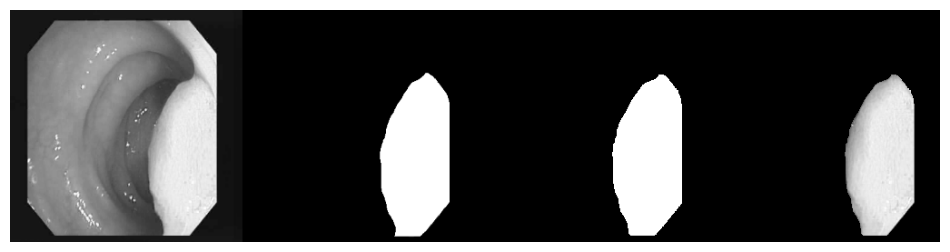

 Epoch: 74 of 100, Iter.: 31 of 31, Train Loss: -0.930957, IoU: 0.947589, Dice: 0.968499
 Epoch: 74 of 100, Iter.: 31 of 31, Valid Loss: -0.625703, IoU: 0.751225, Dice: 0.829262


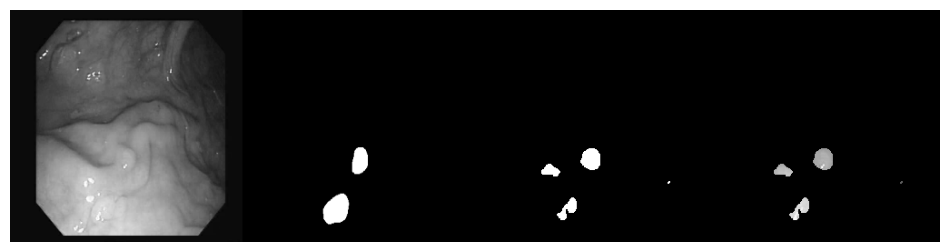

 Epoch: 75 of 100, Iter.: 31 of 31, Train Loss: -0.932694, IoU: 0.950759, Dice: 0.970929
 Epoch: 75 of 100, Iter.: 31 of 31, Valid Loss: -0.621218, IoU: 0.750510, Dice: 0.827158


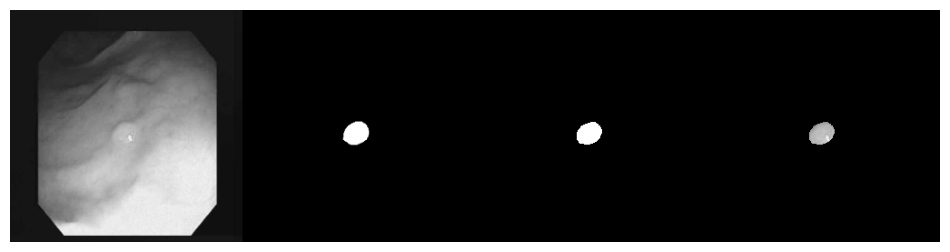

 Epoch: 76 of 100, Iter.: 31 of 31, Train Loss: -0.936006, IoU: 0.952155, Dice: 0.971829
 Epoch: 76 of 100, Iter.: 31 of 31, Valid Loss: -0.614073, IoU: 0.740431, Dice: 0.818241


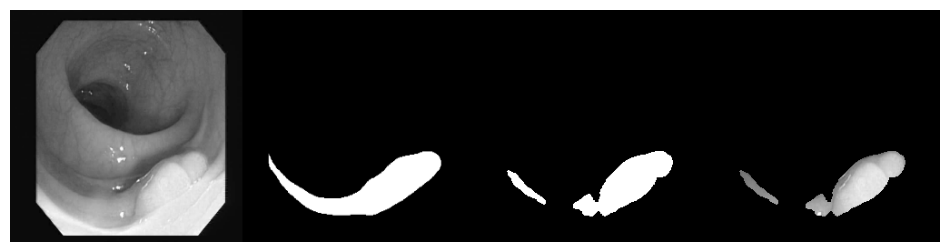

 Epoch: 77 of 100, Iter.: 31 of 31, Train Loss: -0.935681, IoU: 0.953138, Dice: 0.972621
 Epoch: 77 of 100, Iter.: 31 of 31, Valid Loss: -0.637477, IoU: 0.756958, Dice: 0.833313


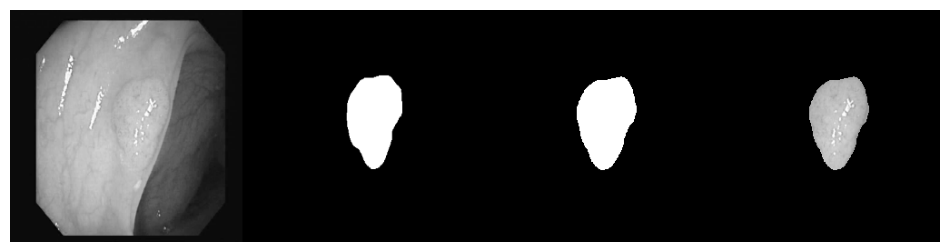

 Epoch: 78 of 100, Iter.: 31 of 31, Train Loss: -0.937376, IoU: 0.954916, Dice: 0.974114
 Epoch: 78 of 100, Iter.: 31 of 31, Valid Loss: -0.631544, IoU: 0.756200, Dice: 0.834253


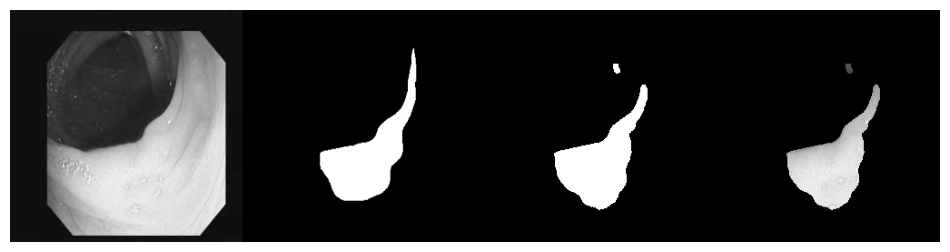

 Epoch: 79 of 100, Iter.: 31 of 31, Train Loss: -0.939779, IoU: 0.957394, Dice: 0.975667
 Epoch: 79 of 100, Iter.: 31 of 31, Valid Loss: -0.639453, IoU: 0.758973, Dice: 0.835424


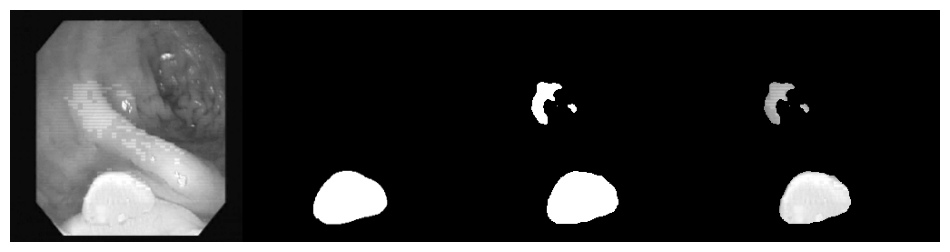

 Epoch: 80 of 100, Iter.: 31 of 31, Train Loss: -0.941610, IoU: 0.959054, Dice: 0.976592
 Epoch: 80 of 100, Iter.: 31 of 31, Valid Loss: -0.640962, IoU: 0.761721, Dice: 0.837053


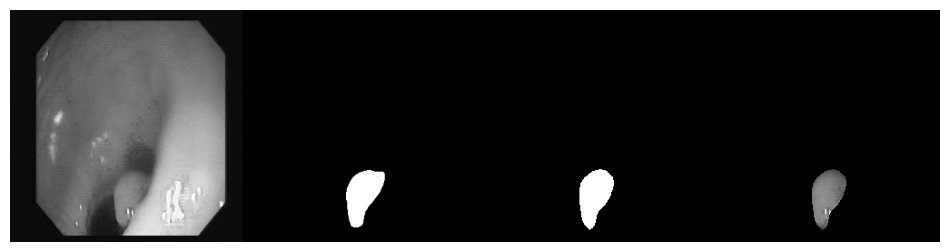

 Epoch: 81 of 100, Iter.: 31 of 31, Train Loss: -0.943029, IoU: 0.959162, Dice: 0.976639
 Epoch: 81 of 100, Iter.: 31 of 31, Valid Loss: -0.632116, IoU: 0.748626, Dice: 0.827097


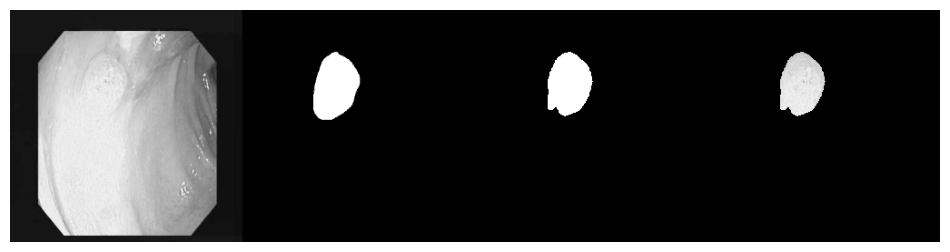

 Epoch: 82 of 100, Iter.: 31 of 31, Train Loss: -0.942838, IoU: 0.958815, Dice: 0.976277
 Epoch: 82 of 100, Iter.: 31 of 31, Valid Loss: -0.612704, IoU: 0.747105, Dice: 0.824979


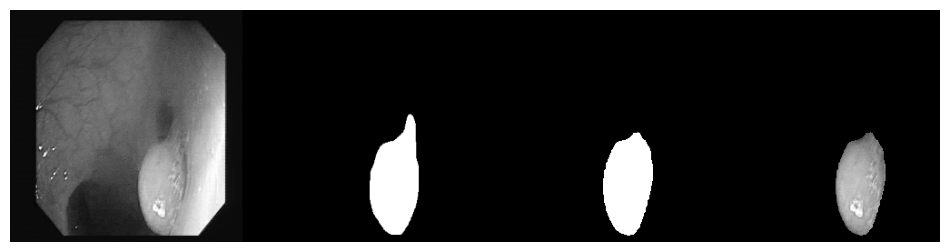

 Epoch: 83 of 100, Iter.: 31 of 31, Train Loss: -0.944455, IoU: 0.959593, Dice: 0.976741
 Epoch: 83 of 100, Iter.: 31 of 31, Valid Loss: -0.624838, IoU: 0.750930, Dice: 0.828819


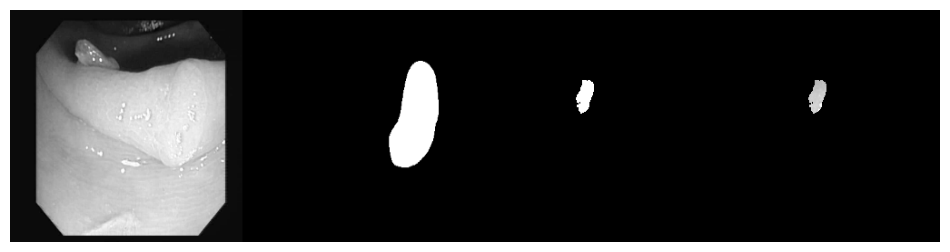

 Epoch: 84 of 100, Iter.: 31 of 31, Train Loss: -0.947901, IoU: 0.962648, Dice: 0.978522
 Epoch: 84 of 100, Iter.: 31 of 31, Valid Loss: -0.651840, IoU: 0.769638, Dice: 0.843131


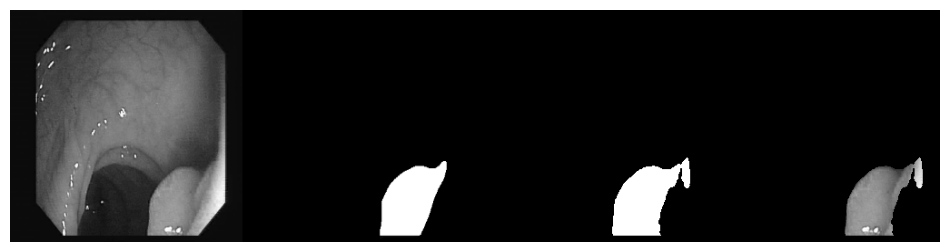

 Epoch: 85 of 100, Iter.: 31 of 31, Train Loss: -0.947354, IoU: 0.961796, Dice: 0.978135
 Epoch: 85 of 100, Iter.: 31 of 31, Valid Loss: -0.640509, IoU: 0.753920, Dice: 0.830134


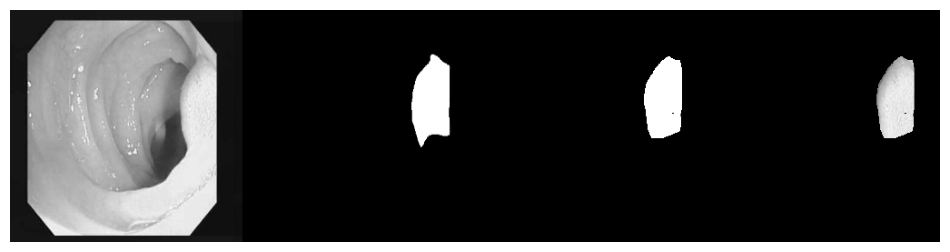

 Epoch: 86 of 100, Iter.: 31 of 31, Train Loss: -0.949670, IoU: 0.962823, Dice: 0.978731
 Epoch: 86 of 100, Iter.: 31 of 31, Valid Loss: -0.643698, IoU: 0.761489, Dice: 0.836006


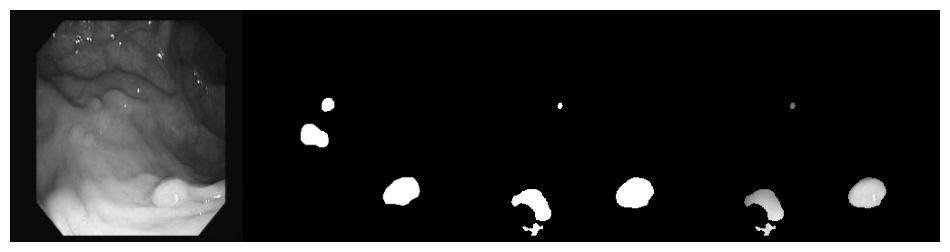

 Epoch: 87 of 100, Iter.: 31 of 31, Train Loss: -0.948383, IoU: 0.962066, Dice: 0.978258
 Epoch: 87 of 100, Iter.: 31 of 31, Valid Loss: -0.621400, IoU: 0.750687, Dice: 0.829170


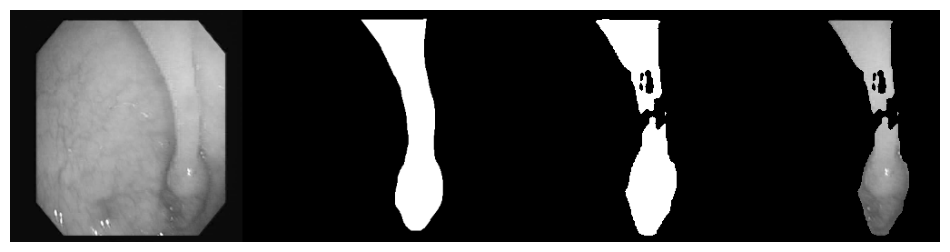

 Epoch: 88 of 100, Iter.: 31 of 31, Train Loss: -0.945620, IoU: 0.958016, Dice: 0.976162
 Epoch: 88 of 100, Iter.: 31 of 31, Valid Loss: -0.643562, IoU: 0.760893, Dice: 0.836568


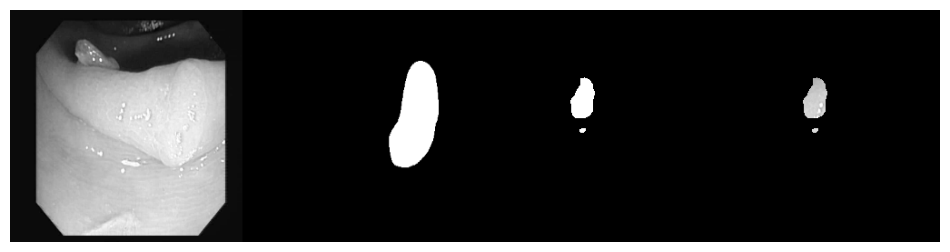

 Epoch: 89 of 100, Iter.: 31 of 31, Train Loss: -0.952129, IoU: 0.963950, Dice: 0.979326
 Epoch: 89 of 100, Iter.: 31 of 31, Valid Loss: -0.632564, IoU: 0.759418, Dice: 0.835720


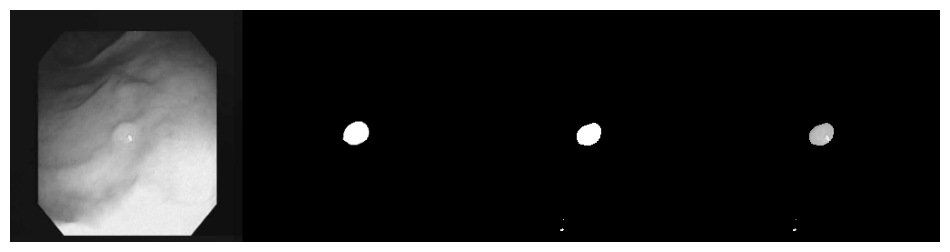

 Epoch: 90 of 100, Iter.: 31 of 31, Train Loss: -0.951570, IoU: 0.964587, Dice: 0.979743
 Epoch: 90 of 100, Iter.: 31 of 31, Valid Loss: -0.640464, IoU: 0.759828, Dice: 0.834461


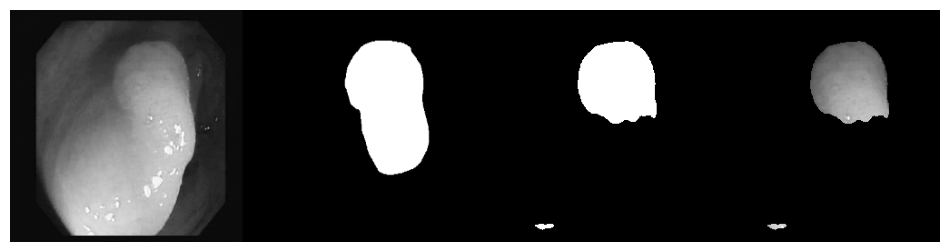

 Epoch: 91 of 100, Iter.: 31 of 31, Train Loss: -0.952040, IoU: 0.964290, Dice: 0.979633
 Epoch: 91 of 100, Iter.: 31 of 31, Valid Loss: -0.643736, IoU: 0.767928, Dice: 0.842600


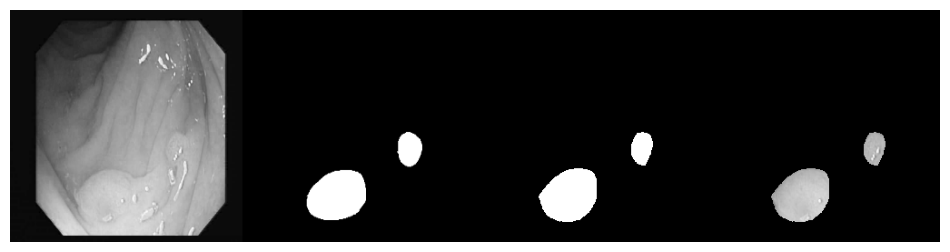

 Epoch: 92 of 100, Iter.: 31 of 31, Train Loss: -0.953611, IoU: 0.964058, Dice: 0.978707
 Epoch: 92 of 100, Iter.: 31 of 31, Valid Loss: -0.632742, IoU: 0.756023, Dice: 0.833392


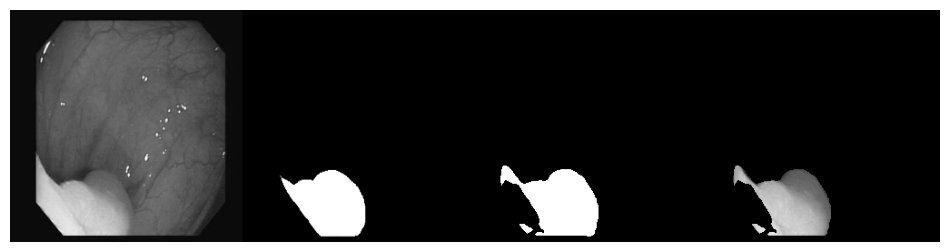

 Epoch: 93 of 100, Iter.: 31 of 31, Train Loss: -0.954323, IoU: 0.966039, Dice: 0.980651
 Epoch: 93 of 100, Iter.: 31 of 31, Valid Loss: -0.653062, IoU: 0.771081, Dice: 0.843691


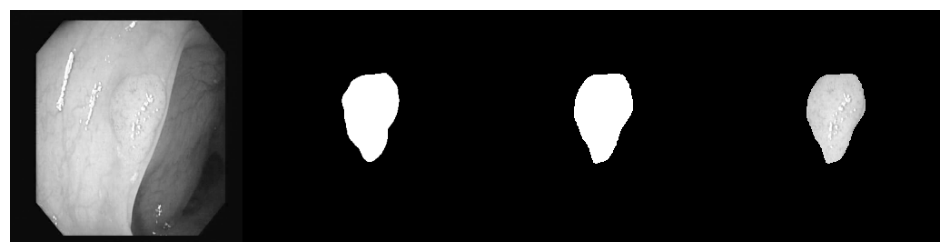

 Epoch: 94 of 100, Iter.: 31 of 31, Train Loss: -0.956668, IoU: 0.968035, Dice: 0.981812
 Epoch: 94 of 100, Iter.: 31 of 31, Valid Loss: -0.655188, IoU: 0.766286, Dice: 0.840484


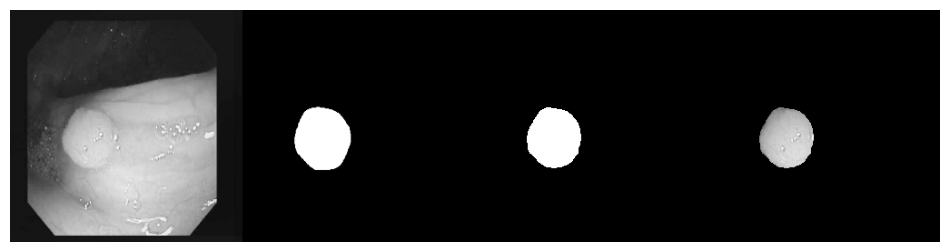

 Epoch: 95 of 100, Iter.: 31 of 31, Train Loss: -0.958785, IoU: 0.969651, Dice: 0.982593
 Epoch: 95 of 100, Iter.: 31 of 31, Valid Loss: -0.639279, IoU: 0.765746, Dice: 0.840867


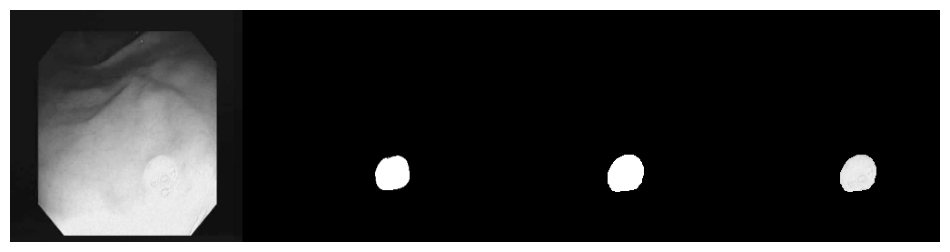

 Epoch: 96 of 100, Iter.: 31 of 31, Train Loss: -0.958727, IoU: 0.969927, Dice: 0.982824
 Epoch: 96 of 100, Iter.: 31 of 31, Valid Loss: -0.626779, IoU: 0.755170, Dice: 0.832109


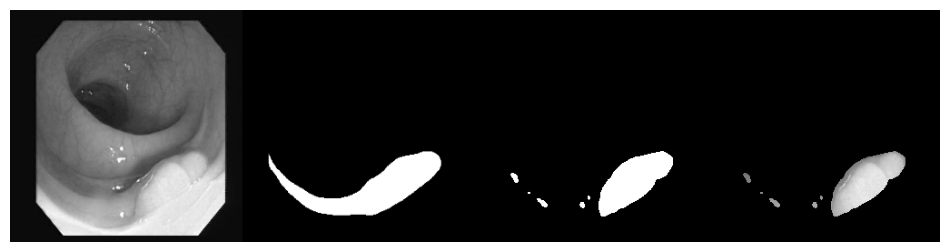

 Epoch: 97 of 100, Iter.: 31 of 31, Train Loss: -0.957508, IoU: 0.968107, Dice: 0.981920
 Epoch: 97 of 100, Iter.: 31 of 31, Valid Loss: -0.651675, IoU: 0.764102, Dice: 0.840067


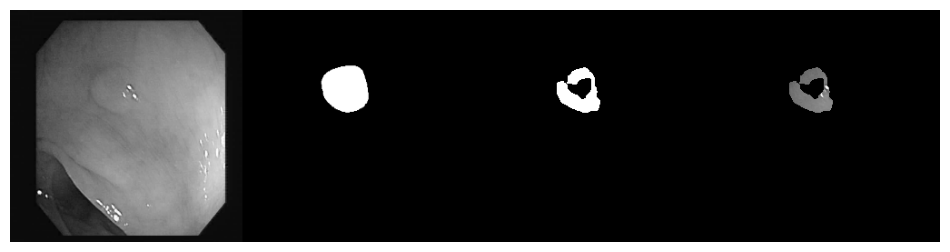

 Epoch: 98 of 100, Iter.: 31 of 31, Train Loss: -0.959041, IoU: 0.969204, Dice: 0.982618
 Epoch: 98 of 100, Iter.: 31 of 31, Valid Loss: -0.627226, IoU: 0.758873, Dice: 0.835676


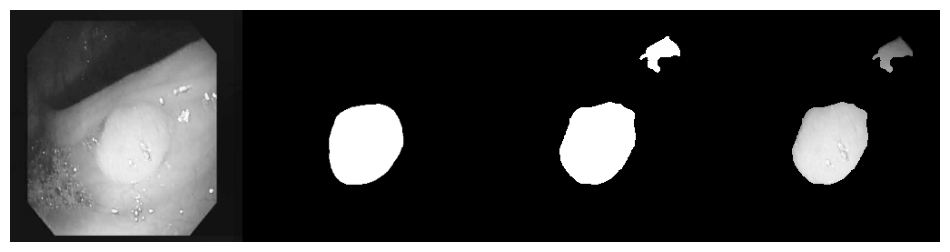

 Epoch: 99 of 100, Iter.: 31 of 31, Train Loss: -0.962678, IoU: 0.971700, Dice: 0.983992
 Epoch: 99 of 100, Iter.: 31 of 31, Valid Loss: -0.648353, IoU: 0.769230, Dice: 0.843728


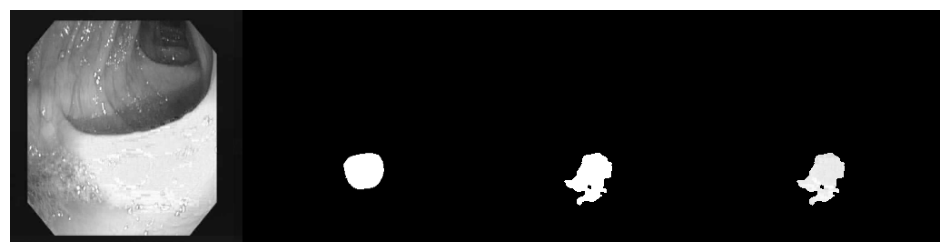

CPU times: user 13min 17s, sys: 8min 31s, total: 21min 49s
Wall time: 15min 35s


In [12]:

%%time
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test
from ploting import plot_model_prediction

data_name = 'ISIC'

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch = -1
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

for epoch in range(epochs):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks), len(dataloader_train), running_loss/(i+1), running_iou/(i+1), run
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, ining_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 0:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    if epoch+1 % 10 == 0:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
        for i, (metric, value) in enumerate(metrics.items()):
            axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=3)
            axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=3)
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel('Loss')
            axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
            axs[i].legend(loc='best')
        plt.show()
    
    lst_epoch_metric.append([round(epoch_train_loss,2), round(epoch_val_loss,2), round(epoch_train_iou,2), 
                             round(epoch_val_iou,2), round(epoch_train_dice,2), round(epoch_val_dice,2)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_iou = epoch if best_iou == epoch_val_iou else best_epoch_iou
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
#     elif best_epoch + patience < epoch:
#         print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
#         break

# load once more and write all the losses down (othw can miss the last 10)
state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'metric_{model_name}_{data_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_IOU:0.7711, Best_DiceScore:0.8437


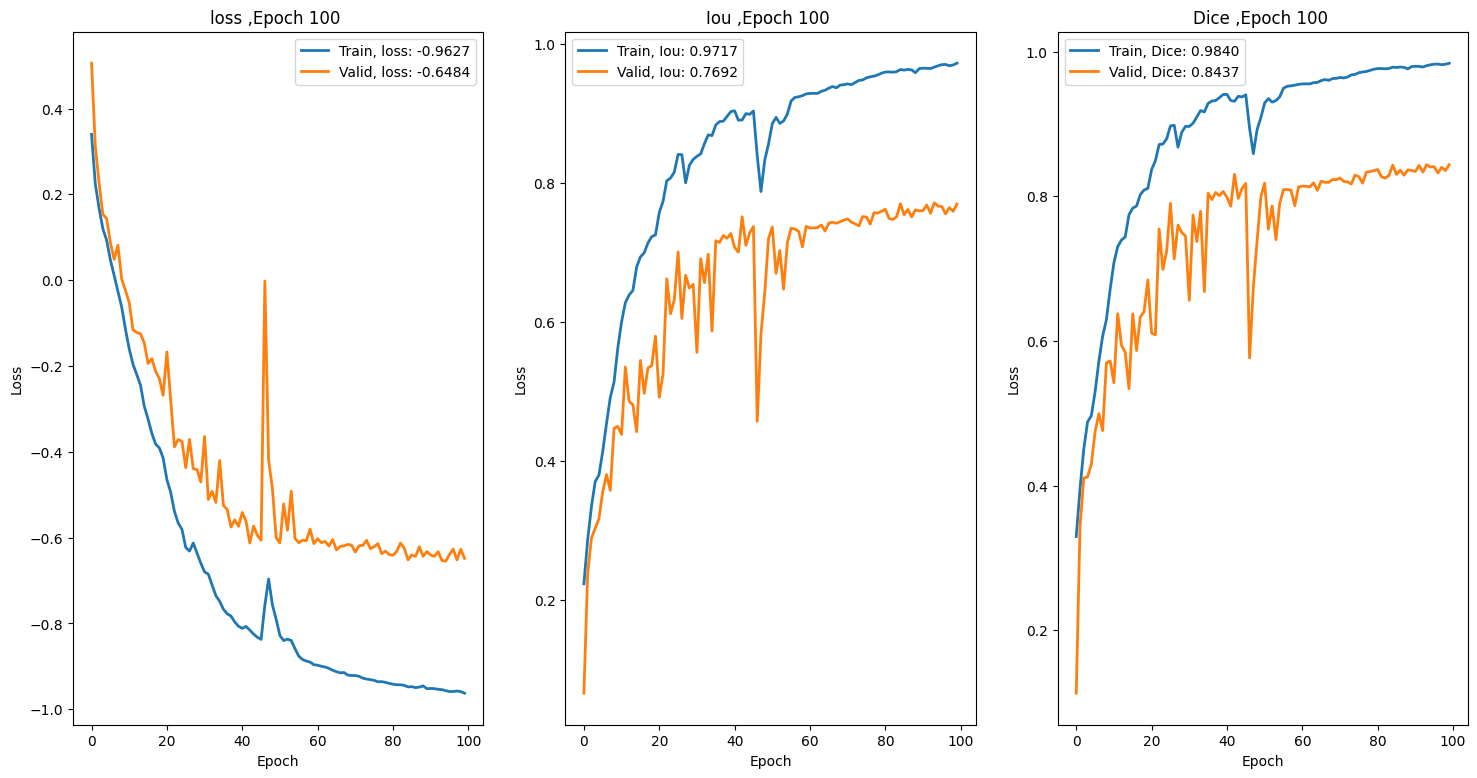

In [13]:
print(f'Validationset 기준 \nBest_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

# metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
#            'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
#            'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
    axs[i].legend(loc='best')
plt.show()